In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import shap

warnings.filterwarnings('ignore')

golf = pd.read_csv('golfscores.csv')

golf = golf.dropna(subset=['date'])

golf['date'] = pd.to_datetime(golf['date'])

golf['fairway'] = golf['fairway'].astype('category')
golf['green'] = golf['green'].astype('category')

golf_data = golf[['hole', 'par', 'distance', 'handicap',
      # 'fairway', 'green', 
                  'putts', 'chips', 'penalties', 'to_par']]

green_dummies = pd.get_dummies(golf['green'], prefix='green')
fairway_dummies = pd.get_dummies(golf['fairway'], prefix='fairway')

# Concatenate dummy variables to original dataframe
golf_expanded = pd.concat([golf, green_dummies, fairway_dummies], axis=1)

# Calculate par-specific to_par
golf_expanded['to_par_3'] = golf_expanded.apply(lambda row: row['to_par'] if row['par'] == 3 else 0, axis=1)
golf_expanded['to_par_4'] = golf_expanded.apply(lambda row: row['to_par'] if row['par'] == 4 else 0, axis=1)
golf_expanded['to_par_5'] = golf_expanded.apply(lambda row: row['to_par'] if row['par'] == 5 else 0, axis=1)

# Group by round (i.e., date)
golf_rounds = golf_expanded.groupby('date').agg({
   'course':'first',
    'hole':'max',
    'score': 'sum',
    'to_par': 'sum',
    'par': 'sum',
    'to_par_3': 'sum',
    'to_par_4': 'sum',
    'to_par_5': 'sum',
    'chips': 'sum',
    'putts': 'sum',
    **{col: 'sum' for col in green_dummies.columns},
    **{col: 'sum' for col in fairway_dummies.columns}
}).reset_index()

# Rename for clarity
golf_rounds.rename(columns={
    'score': 'total_score',
    'to_par': 'total_to_par',
    'par': 'total_par',
    'to_par_3': 'par3_to_par',
    'to_par_4': 'par4_to_par',
    'to_par_5': 'par5_to_par',
    'chips': 'total_chips',
    'putts': 'total_putts'
}, inplace=True)

golf_rounds['to_par_18'] = golf_rounds.apply(
    lambda row: row['total_to_par'] * 2 if row['hole'] == 9 else row['total_to_par'],
    axis=1
)

# Intro

I suck at golf. According to the USGA, I am currently a 20.6 handicap. This means that even on my best days, I still average worse than a bogey on a given hole. My goal is to become a **15 handicap**. Better yet, I'd prefer to reach that milestone before my dad, who also sucks but does manage to practice more than me.

I would love to get better, but that takes lots of time and effort. Given I work full-time during the day, take classes in the evening, like to travel, and do all these other random things, it is *not realistic* to think that I could somehow quickly improve my golf game by 5 strokes. 

The *golf swing* is only part of the game. Course management and understanding strategy is a major part of scoring, and getting this is often how high handicaps see improvement. I thought: What if I can use data about my game to get a better understanding of where I gain strokes, or more likely lose strokes, and use my data science background to come up with a gameplan to get me to a 15?

I track all my rounds on [18 Birdies](https://18birdies.com), which allows me to keep stats on my **fairways**, **greens**, **chips**, and **putts** per round. It also has each hole's **handicap rating**, allowing me to see how I fare on the easiest and hardest holes on the course. 

Using this data, and a little bit more that I'll get to, I set out to better understand my golf game, and hopefully come away with a gameplan to get me to a **15 handicap**.

# Overview

To begin, let's level-set with seeing where I've been over my last 20 rounds. Below is an overview of all the rounds making up my handicap, my average scores by different pars, best rounds, and, just for fun, where I've made my few birdies.

In [68]:
# === LOWEST 18-HOLE ROUND ===
# Only include dates where hole 18 was played (full round)
eighteen_hole_rounds = golf[golf['hole'] == 18]['date'].unique()
full_rounds = golf[golf['date'].isin(eighteen_hole_rounds)]

round_scores_18 = full_rounds.groupby('date').agg({
    'score': 'sum',
    'to_par': 'sum'
}).reset_index()

lowest_18 = round_scores_18.loc[round_scores_18['score'].idxmin()]

# === LOWEST 9-HOLE ROUND ===
def get_half_scores(df):
    results = []
    for date, group in df.groupby('date'):
        front = group[group['hole'].between(1, 9)]
        back = group[group['hole'].between(10, 18)]
        if len(front) == 9:
            results.append({'date': date, 'half': 'front', 'score': front['score'].sum(), 'to_par': front['to_par'].sum()})
        if len(back) == 9:
            results.append({'date': date, 'half': 'back', 'score': back['score'].sum(), 'to_par': back['to_par'].sum()})
    return pd.DataFrame(results)

nine_hole_scores = get_half_scores(golf)
lowest_9 = nine_hole_scores.loc[nine_hole_scores['score'].idxmin()]

# Calculate metrics
avg_to_par = round(golf['to_par'].mean() * 18)
common_courses = golf['course'].value_counts().head(1)
avg_by_par = golf.groupby('par')['score'].mean().reset_index()
avg_by_par['par'] = avg_by_par['par'].astype(int)
avg_by_par['score'] = avg_by_par['score'].round(1)  # Keep 1 decimal for bar labels

longest_hole = golf.loc[golf['distance'].idxmax()]
birdies = golf[golf['to_par'] == -1][['hole', 'course']].reset_index()
birdies['hole'] = birdies['hole'].astype(int)



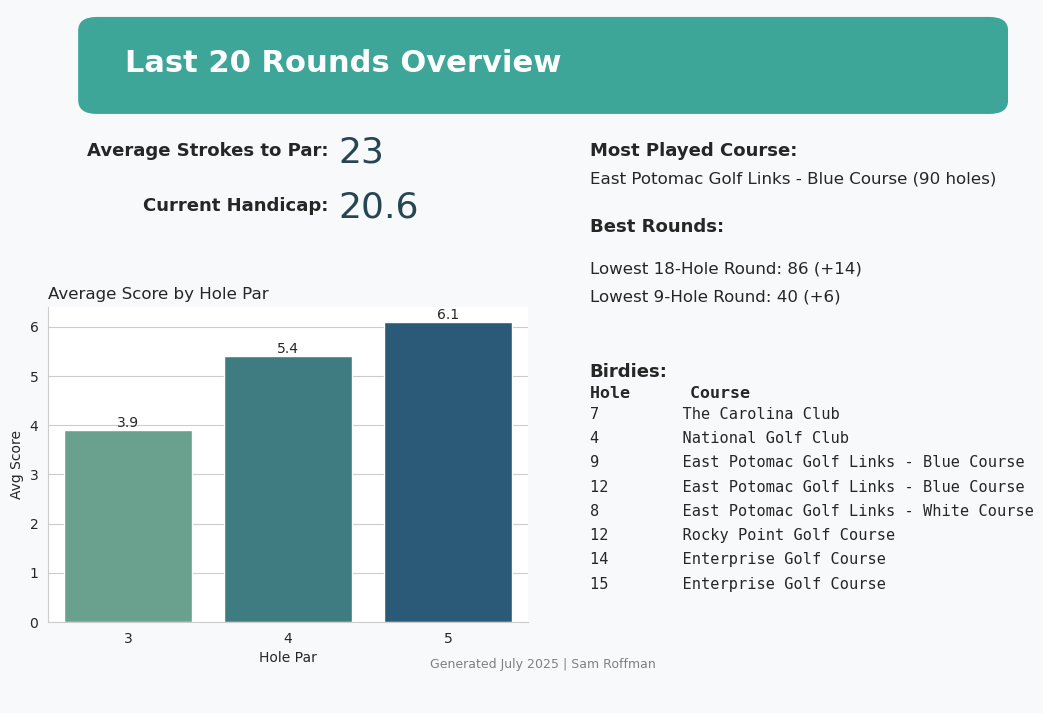

In [73]:
# Customize global style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "DejaVu Sans"  # Replace with 'Lato' or similar if registered

# Begin plot layout
fig, ax = plt.subplots(figsize=(12, 9))
ax.axis('off')
fig.patch.set_facecolor('#f8f9fa')

# ==== Header ====
ax.add_patch(patches.FancyBboxPatch((0.02, 0.87), 0.96, 0.1,
                                    boxstyle="round,pad=0.02",
                                    edgecolor="none", facecolor="#2a9d8f", alpha=0.9))
ax.text(0.05, 0.91, "Last 20 Rounds Overview", fontsize=22, color="white", weight='bold')

# ==== Section 1: Average To Par ====
ax.text(0.01, 0.79, f"Average Strokes to Par:", fontsize=13, weight='bold')
ax.text(0.28, 0.78, f"{avg_to_par}", fontsize=26, color="#264653")

ax.text(0.07, 0.71, f"Current Handicap:", fontsize=13, weight='bold')
ax.text(0.28, 0.7, f"20.6", fontsize=26, color="#264653")

# ==== Section 2: Most Common Courses ====
ax.text(0.55, 0.79, "Most Played Course:", fontsize=13, weight='bold')
for i, (course, count) in enumerate(common_courses.items()):
    ax.text(0.55, 0.75 - i * 0.035, f"{course} ({count} holes)", fontsize=12)

# ==== Section 3: Bar Plot of Scores by Par ====
ax_bar = fig.add_axes([0.1, 0.2, 0.4, 0.35])
sns.barplot(data=avg_by_par, x='par', y='score', ax=ax_bar, palette='crest')
ax_bar.set_title("Average Score by Hole Par", fontsize=12, loc='left')
ax_bar.set_xlabel("Hole Par")
ax_bar.set_ylabel("Avg Score")
ax_bar.spines[['top', 'right']].set_visible(False)

# Add labels on top of bars
for container in ax_bar.containers:
    ax_bar.bar_label(container, labels=[f"{v:.1f}" for v in container.datavalues], label_type='edge', fontsize=10)


ax.text(0.55, 0.68, "Best Rounds:", fontsize=13, weight='bold')
# Lowest 18-hole round
ax.text(0.55, 0.62, f"Lowest 18-Hole Round: {int(lowest_18['score'])} (+{int(lowest_18['to_par'])})", fontsize=12)

# Lowest 9-hole round
ax.text(0.55, 0.58, f"Lowest 9-Hole Round: {int(lowest_9['score'])} (+{int(lowest_9['to_par'])})", fontsize=12)

# ==== Section 5: Birdies Table ====
ax.text(0.55, 0.47, "Birdies:", fontsize=13, weight='bold')
if not birdies.empty:
    ax.text(0.55, 0.44, f"{'Hole':<10}Course", fontsize=12, weight='bold', family='monospace')
    for i, row in birdies.iterrows():
        if i < 20:  # Show only the first 6 to avoid overlap
            ax.text(0.55, 0.41 - i * 0.035,
                    f"{str(row['hole']):<10}{row['course']}", fontsize=11, family='monospace')
else:
    ax.text(0.55, 0.43, "No birdies recorded.", fontsize=11, family='monospace')

# ==== Footer ====
ax.text(0.5, 0.05, "Generated July 2025 | Sam Roffman", fontsize=9, color="gray", ha='center')

plt.savefig("golf_slick_sheet.png", dpi=300, bbox_inches='tight')
plt.show()



# Exploratory Data Analysis (EDA)

Ultimately, I would like to build a statistical model, using machine learning to understand the key components of my score. Before that, however, it is important to understand the data we are using. In data science, this is done with *Exploratory Data Analysis*, or EDA. Below, we will look at my recent trends over time, followed by some breakdowns of scores and other stats within different groupings of holes. 

Once we have a good subjective understanding of the inner workings of my scores, we can move to machine learning or more complex statistical analysis to attempt to gain an **objective, mathematical answer** to the question: *What course management strategy can I follow to become a 15 handicap?*

## Trends

Below, I've plotted my total score over time, accompanied by a 3-round rolling average, and a trendline.

In [107]:
# Compute average to_par per par type per round
def average_to_par_by_par_type(df):
    results = []
    for date, group in df.groupby('date'):
        par3 = group[group['par'] == 3]['to_par']
        par4 = group[group['par'] == 4]['to_par']
        par5 = group[group['par'] == 5]['to_par']
        results.append({
            'date': date,
            'avg_par3_to_par': par3.mean() if not par3.empty else None,
            'avg_par4_to_par': par4.mean() if not par4.empty else None,
            'avg_par5_to_par': par5.mean() if not par5.empty else None
        })
    return pd.DataFrame(results)

# Merge into golf_rounds
avg_pars_df = average_to_par_by_par_type(golf)
golf_rounds = golf_rounds.merge(avg_pars_df, on='date', how='left')


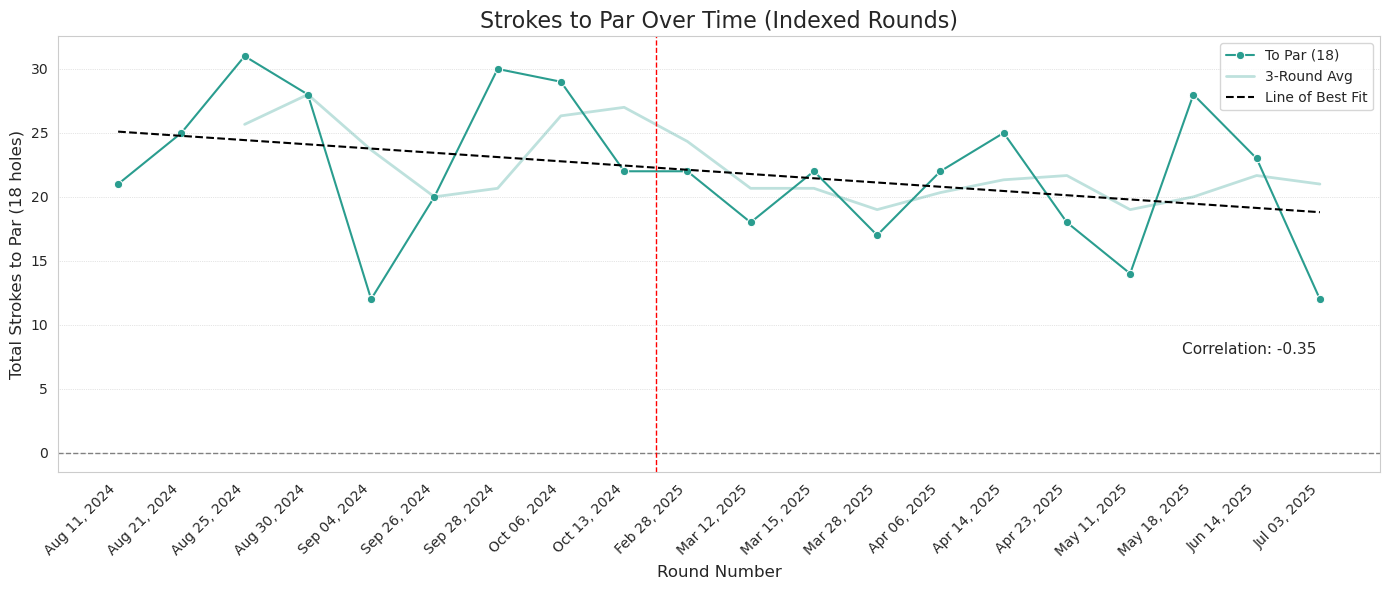

In [105]:
# Recreate index if needed
golf_rounds = golf_rounds.sort_values('date').reset_index(drop=True)
golf_rounds['x'] = range(len(golf_rounds))
golf_rounds['rolling_to_par_18'] = golf_rounds['to_par_18'].rolling(3).mean()

# Calculate correlation coefficient
corr = golf_rounds['x'].corr(golf_rounds['to_par_18'])

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot raw data and rolling average
sns.lineplot(data=golf_rounds, x='x', y='to_par_18', marker='o', color='#2a9d8f', ax=ax1, label='To Par (18)')
sns.lineplot(data=golf_rounds, x='x', y='rolling_to_par_18', ax=ax1,
             color='#2a9d8f', linewidth=2, linestyle='-', label='3-Round Avg', alpha=0.3)

# Line of best fit
model = LinearRegression().fit(golf_rounds[['x']], golf_rounds['to_par_18'])
y_pred = model.predict(golf_rounds[['x']])
ax1.plot(golf_rounds['x'], y_pred, color='black', linestyle='--', linewidth=1.5, label='Line of Best Fit')

# Annotate correlation coefficient
ax1.text(0.85, 0.3, f"Correlation: {corr:.2f}", transform=ax1.transAxes,
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.6))

# Formatting
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
if red_line_x is not None:
    ax1.axvline(x=red_line_x, color='red', linestyle='--', linewidth=1)

ax1.grid(axis='x', visible=False)
ax1.grid(axis='y', linestyle=':', linewidth=0.5)
ax1.set_ylabel('Total Strokes to Par (18 holes)', fontsize=12)
ax1.set_xlabel('Round Number', fontsize=12)
ax1.set_title('Strokes to Par Over Time (Indexed Rounds)', fontsize=16)
ax1.set_xticks(golf_rounds['x'])
ax1.set_xticklabels(golf_rounds['date'].dt.strftime('%b %d, %Y'), rotation=45, ha='right')
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()


Our trendline shows a `correlation coeficient` of **-0.35**. This indicates we are, infact, **Trending!** We have statistical evidence that there is a medium-strength, negative relationship between round number (least recent to most recent) and score. This means that from my last 20 rounds, as I have played more, my expected score has gone down. (Approx. 1/3 of a stroke per round).

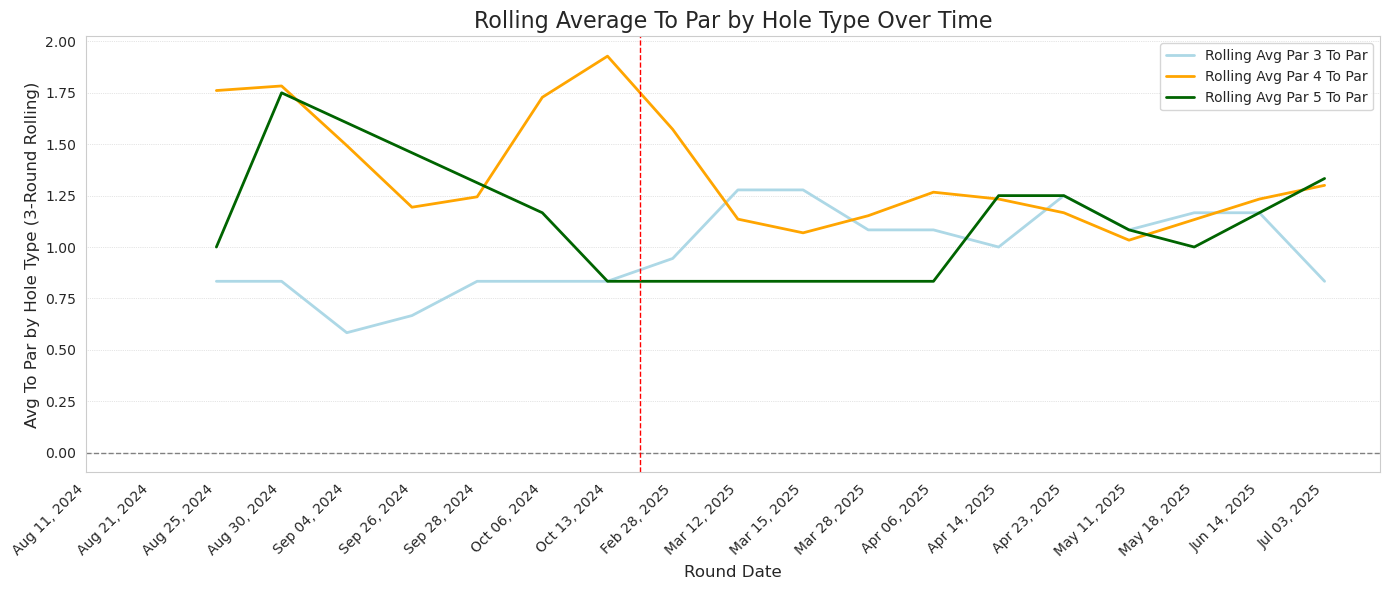

In [112]:
# Add 3-round rolling averages
golf_rounds['rolling_avg_par3_to_par'] = golf_rounds['avg_par3_to_par'].rolling(3).mean()
golf_rounds['rolling_avg_par4_to_par'] = golf_rounds['avg_par4_to_par'].rolling(3).mean()
golf_rounds['rolling_avg_par5_to_par'] = golf_rounds['avg_par5_to_par'].rolling(3).mean()


# Plot 2: Rolling Avg To Par by Hole Type
fig, ax2 = plt.subplots(figsize=(14, 6))

sns.lineplot(data=golf_rounds, x='x', y='rolling_avg_par3_to_par',
             color='lightblue', label='Rolling Avg Par 3 To Par', linewidth=2, ax=ax2)
sns.lineplot(data=golf_rounds, x='x', y='rolling_avg_par4_to_par',
             color='orange', label='Rolling Avg Par 4 To Par', linewidth=2, ax=ax2)
sns.lineplot(data=golf_rounds, x='x', y='rolling_avg_par5_to_par',
             color='darkgreen', label='Rolling Avg Par 5 To Par', linewidth=2, ax=ax2)

ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
if red_line_x is not None:
    ax2.axvline(x=red_line_x, color='red', linestyle='--', linewidth=1)

ax2.grid(axis='x', visible=False)
ax2.grid(axis='y', linestyle=':', linewidth=0.5)
ax2.set_ylabel('Avg To Par by Hole Type (3-Round Rolling)', fontsize=12)
ax2.set_xlabel('Round Date', fontsize=12)
ax2.set_xticks(golf_rounds['x'])
ax2.set_xticklabels(golf_rounds['date'].dt.strftime('%b %d, %Y'), rotation=45, ha='right')
ax2.set_title('Rolling Average To Par by Hole Type Over Time', fontsize=16)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



Here, we are looking at my average scores to par by par 3s, 4s, and 5s. While there aren't any significant downward trends here, I am pleased to see an apparent decrease in variance between the three lines. This indicates less volitility in my recent rounds compared to my older ones, which is always a good thing.

In [113]:
# Ensure round index exists
golf_rounds = golf_rounds.sort_values('date').reset_index(drop=True)
golf_rounds['x'] = range(len(golf_rounds))

# Normalize stats for 9-hole rounds
golf_rounds['is_9'] = golf_rounds['total_par'] < 70  # crude proxy

# Normalize dummy-summed columns
golf_rounds['fairways_hit_norm'] = golf_rounds.apply(
    lambda row: row['fairway_hit'] * 2 if row['is_9'] else row['fairway_hit'], axis=1
)
golf_rounds['greens_hit_norm'] = golf_rounds.apply(
    lambda row: row['green_hit'] * 2 if row['is_9'] else row['green_hit'], axis=1
)
golf_rounds['putts_norm'] = golf_rounds.apply(
    lambda row: row['total_putts'] * 2 if row['is_9'] else row['total_putts'], axis=1
)
golf_rounds['chips_norm'] = golf_rounds.apply(
    lambda row: row['total_chips'] * 2 if row['is_9'] else row['total_chips'], axis=1
)

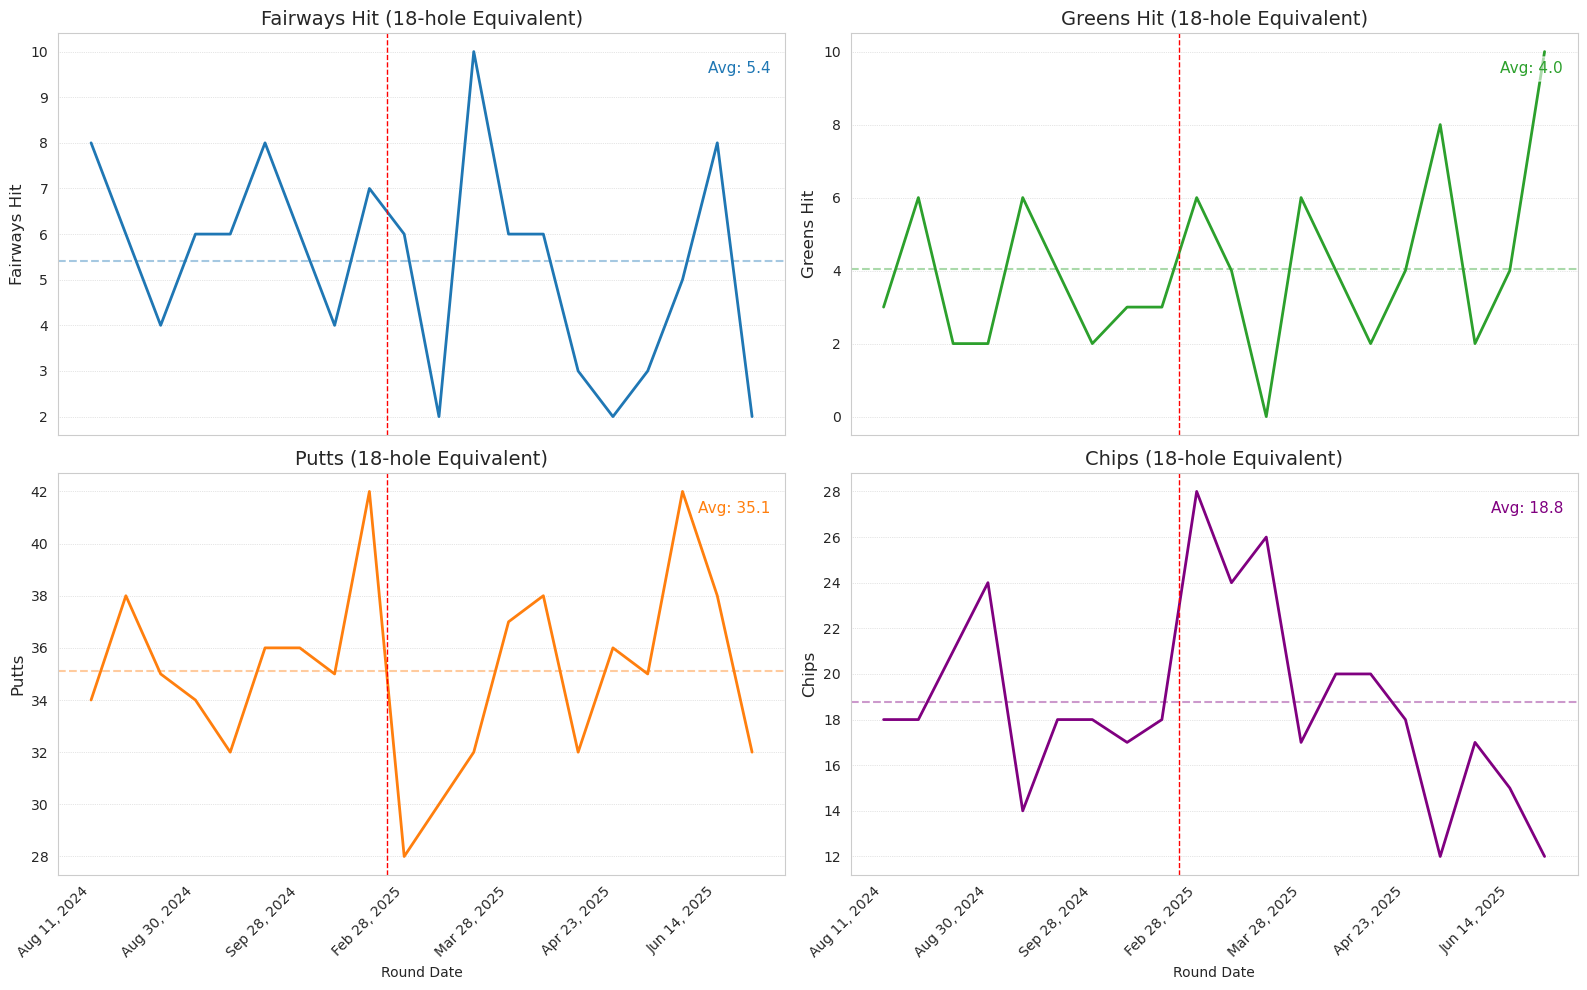

In [123]:
# Set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# Common values
x_vals = golf_rounds['x']
x_labels = golf_rounds['date'].dt.strftime('%b %d, %Y')

# Metric values and config
metrics = [
    ('fairways_hit_norm', 'Fairways Hit', '#1f77b4', axes[0, 0]),
    ('greens_hit_norm', 'Greens Hit', '#2ca02c', axes[0, 1]),
    ('putts_norm', 'Putts', '#ff7f0e', axes[1, 0]),
    ('chips_norm', 'Chips', 'purple', axes[1, 1]),
]

for col, title, color, ax in metrics:
    y_vals = golf_rounds[col]
    avg_val = y_vals.mean()
    
    # Line plot
    ax.plot(x_vals, y_vals, color=color, linewidth=2)
    
    # Avg annotation
    ax.axhline(avg_val, color=color, linestyle='--', alpha=0.4)
    ax.text(0.98, 0.9, f'Avg: {avg_val:.1f}', transform=ax.transAxes,
            ha='right', fontsize=11, color=color,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.6))
    
    # Title and formatting
    ax.set_title(f'{title} (18-hole Equivalent)', fontsize=14)
    ax.set_ylabel(title, fontsize=12)
    ax.grid(axis='x', visible=False)
    ax.grid(axis='y', linestyle=':', linewidth=0.5)
    
    # Red year-split line
    if red_line_x is not None:
        ax.axvline(x=red_line_x, color='red', linestyle='--', linewidth=1)

# X-axis labels
tick_step = 3
xticks_to_show = x_vals[::tick_step]
xtick_labels_to_show = x_labels[::tick_step]

for ax in axes[1, :]:  # bottom row only
    ax.set_xticks(xticks_to_show)
    ax.set_xticklabels(xtick_labels_to_show, rotation=45, ha='right')
    ax.set_xlabel('Round Date')

plt.tight_layout()
plt.show()

Finally, let's look at my stats from this time period. My fairways and putts are all over the map, but there does appear to be good recent trends in greens and chips. This makes sense, as the more greens I hit, the less I have to chip. 

Probably most concerning are my 20-round averages in chips and putts. 2 putts per hole isn't bad, but coupled with over a chip per hole is not a good sign. While 1 chip and 2 putts usually equals a bogey (good for me!), the volatility in my game often means that I will end up with scores in the mid to high 90s, even with these stats.

## Hole-by-Hole Breakdowns

Next up in EDA, I want to do some `groupby` functions to see how the data looks in different subsets. This will help us look for key differences in scoring or stats across different scenarios that occur throughout a round. Below, we will look at different **pars**, **handicaps**, and **hole numbers during a round**.

### Breakdown by Par

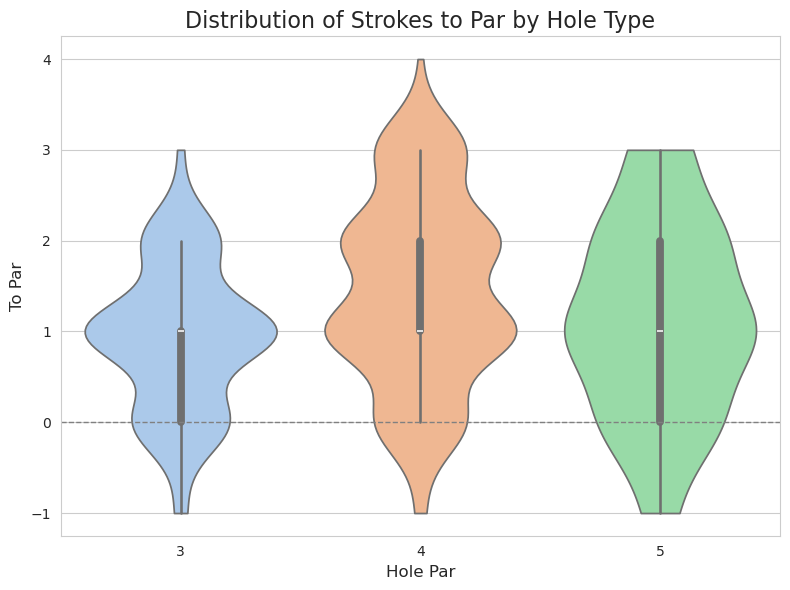

In [130]:
# Ensure 'par' is integer (not float)
golf['par'] = golf['par'].astype(int)

plt.figure(figsize=(8, 6))
sns.violinplot(data=golf, x='par', y='to_par', palette='pastel', cut=0)

# Formatting
plt.title('Distribution of Strokes to Par by Hole Type', fontsize=16)
plt.xlabel('Hole Par', fontsize=12)
plt.ylabel('To Par', fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

This is a violin plot, which is one of my favorie plots for comparing distributions across groups. Think of it as a more detailed boxplot, where the highest values are on top, the middle values are in the middle, and the lowest ones are at the bottom. Violin plots are wider where there is a greater concentration of data. For example, I make lots of bogeys on par 3s, so for the plot on the left, the violin is wider around the value Y = 1 (1 stroke over par). 

In this plot, it is clear there is a lot of variance in my scores on par 4s and 5s, since the violins are wider at the extreme values. I tend to do more consistently on par 3s, which is great.

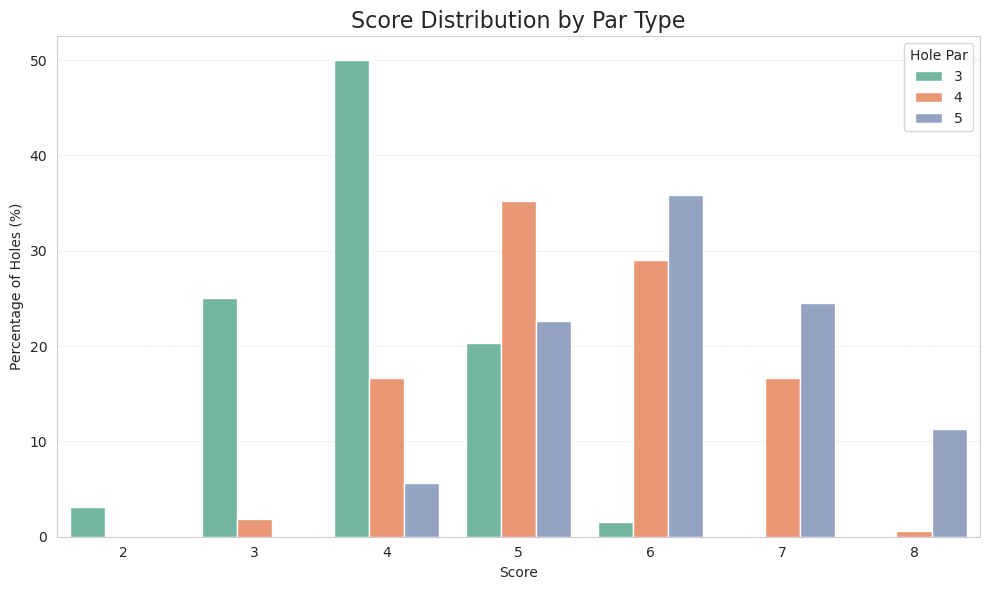

In [137]:
# Clean and prep
golf = golf.dropna(subset=['par', 'score'])
golf['par'] = golf['par'].astype(int)
golf['score'] = golf['score'].astype(int)

# Count scores per par
score_counts = golf.groupby(['par', 'score']).size().reset_index(name='count')

# Total holes per par
par_totals = golf.groupby('par').size().reset_index(name='total')

# Merge and compute %
score_counts = score_counts.merge(par_totals, on='par')
score_counts['percent'] = score_counts['count'] / score_counts['total'] * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=score_counts,
    x='score',
    y='percent',
    hue='par',
    palette='Set2'
)

plt.title('Score Distribution by Par Type', fontsize=16)
plt.xlabel('Score')
plt.ylabel('Percentage of Holes (%)')
plt.legend(title='Hole Par')
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


Here is another way of looking at the data from the violin plot. You can see I make 4 on about 50% of my par 3s, and actually make 3 more often than I make 5 or 6. This is again great news.

More concerning is my record on par 4s. I make double nearly 30% of the time on par 4s, and triple over 15% of the time. Comparing this to par 5s, those values are 25% and 11% respectively. Limiting blow ups on par 4s is going to be key moving forward.

### Breakdown by Difficulty (Handicap)

Next, lets look at holes of different diffculties. For ease of analysis, I have used the handicap system to define holes as **Easy** (handicaps 13-18), **Medium** (handicaps 7-12) and **Hard** (handicaps 1-6). Obviously, these ratings are somewhat subjective, and a *medium* hole on a hard course may be harder than a *hard* hole on an easier course. Nonetheless, this is the system we have.

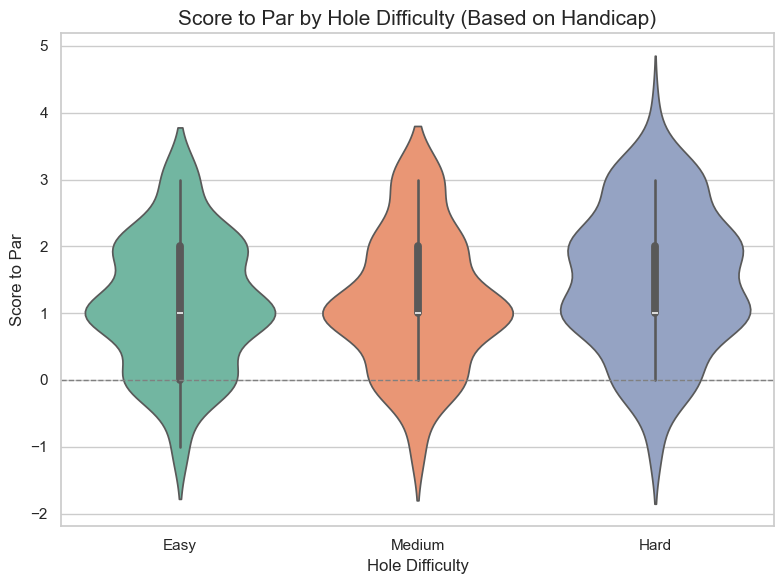

In [139]:
# Create difficulty group
def classify_difficulty(hcp):
    if 1 <= hcp <= 6:
        return 'Hard'
    elif 7 <= hcp <= 12:
        return 'Medium'
    elif 13 <= hcp <= 18:
        return 'Easy'
    else:
        return 'Unknown'

golf['difficulty'] = golf['handicap'].astype(int).apply(classify_difficulty)

# Set plot style
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))

# Create boxplot
sns.violinplot(data=golf, x='difficulty', y='to_par', order=['Easy', 'Medium', 'Hard'], palette='Set2')

# Formatting
plt.title('Score to Par by Hole Difficulty (Based on Handicap)', fontsize=15)
plt.xlabel('Hole Difficulty')
plt.ylabel('Score to Par')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


Looking again at the violin plot, we see a trend that generally makes sense. The center (mean and median) of the distribution of my scores rises as holes get harder. 

One interesting note: There seems to be a higher concentration of doubles (Y=2) on easy holes than hard holes. This may be due to the fact that many easy holes are *Risk / Reward holes*. Maybe I go for the green in 2 on an easy par 5 - if I make it, I have an easy birdie or par. If not, I may be staring at double or worse.

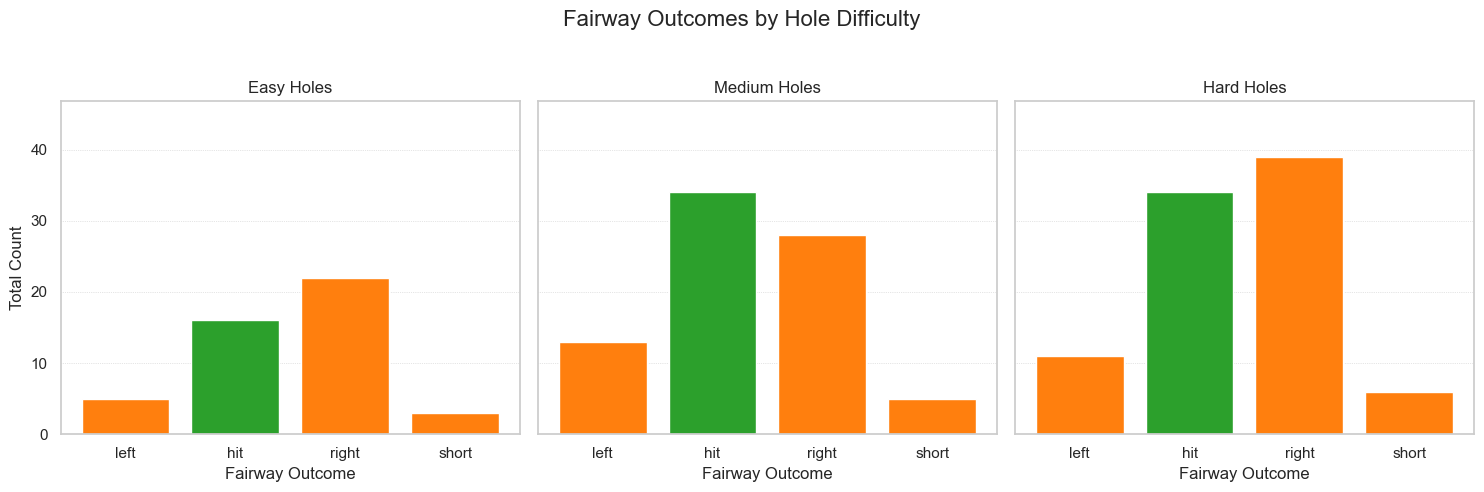

In [154]:
# Define fairway categories and difficulty order
fairway_order = ['left', 'hit', 'right', 'short']
difficulty_order = ['Easy', 'Medium', 'Hard']
colors = ['#ff7f0e', '#2ca02c', '#ff7f0e', '#ff7f0e']  # green for 'hit', orange for others

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot for each difficulty group
for i, difficulty in enumerate(difficulty_order):
    ax = axes[i]
    subset = golf[golf['difficulty'] == difficulty]
    counts = subset['fairway'].value_counts().reindex(fairway_order, fill_value=0)

    bars = ax.bar(fairway_order, counts.values, color=colors)
    ax.set_title(f'{difficulty} Holes')
    ax.set_xlabel('Fairway Outcome')
    if i == 0:
        ax.set_ylabel('Total Count')
    ax.set_ylim(0, max(counts.values) * 1.2)
    ax.grid(axis='x', visible=False)  # remove vertical gridlines
    ax.grid(axis='y', linestyle=':', linewidth=0.5)  # keep light horizontal lines

# Final formatting
plt.suptitle('Fairway Outcomes by Hole Difficulty', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


These barplots show the distribution of my fairways hit and missed. There isn't much to pull out of this, but it is interesting to see that I hit more fairways on *medium* holes than *easy* ones. The raw counts are higher because easy holes are often par 3s, but the `hit` bar is higher than all the rest for *medium* holes.

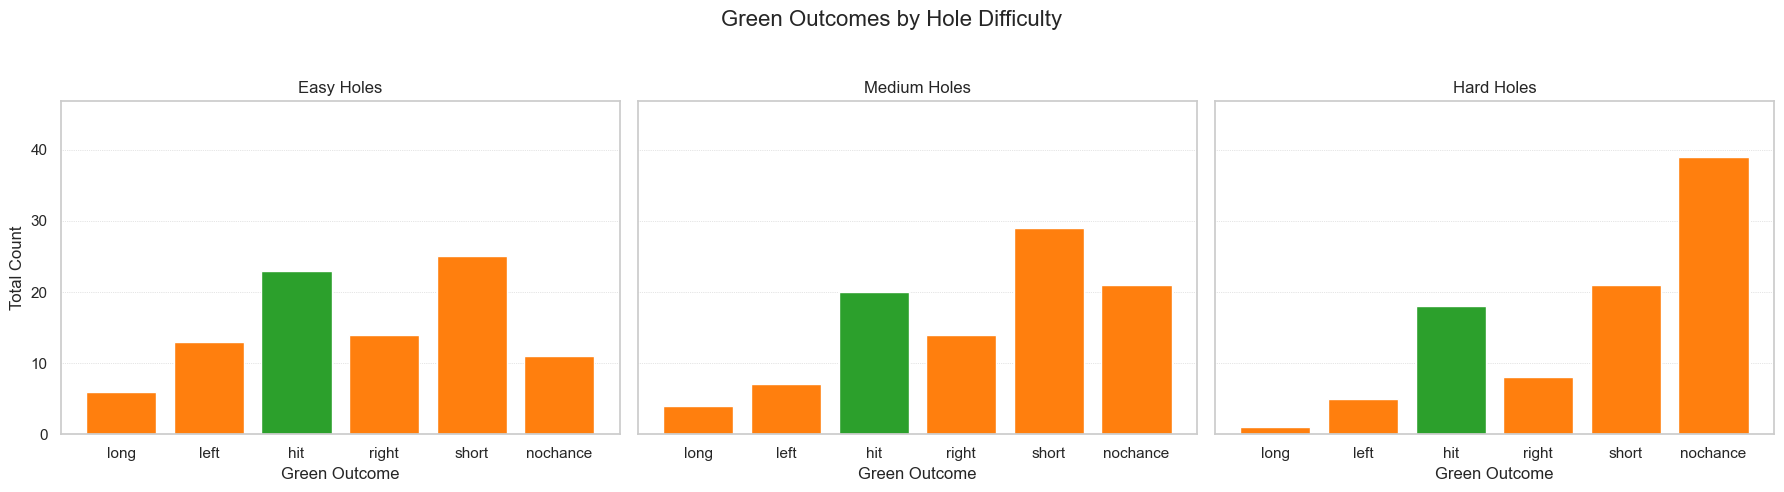

In [153]:
# Define order and colors
green_order = ['long', 'left', 'hit', 'right', 'short', 'nochance']
difficulty_order = ['Easy', 'Medium', 'Hard']
colors = ['#ff7f0e', '#ff7f0e', '#2ca02c', '#ff7f0e', '#ff7f0e', '#ff7f0e']  # green for 'hit'

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot for each difficulty level
for i, difficulty in enumerate(difficulty_order):
    ax = axes[i]
    subset = golf[golf['difficulty'] == difficulty]
    counts = subset['green'].value_counts().reindex(green_order, fill_value=0)

    ax.bar(green_order, counts.values, color=colors)
    ax.set_title(f'{difficulty} Holes')
    ax.set_xlabel('Green Outcome')
    if i == 0:
        ax.set_ylabel('Total Count')
    ax.set_ylim(0, max(counts.values) * 1.2)
    ax.grid(axis='x', visible=False)  # remove vertical gridlines
    ax.grid(axis='y', linestyle=':', linewidth=0.5)  # keep light horizontal lines

# Add overall title and formatting
plt.suptitle('Green Outcomes by Hole Difficulty', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Now we are starting to see something interesting. *Easy* and *Medium* holes have fairly similar green dispersion pattern, but on *Hard* holes, I miss the green more, and have `No Chance` to hit the green almost **40 %** of the time. This is less a comment on my iron play, and more due to the fact that I am not getting off the tee well on hard holes. It doesn't matter if I miss left or right, having no shot at the green (or taking a penalty) is not good for lowering scores.

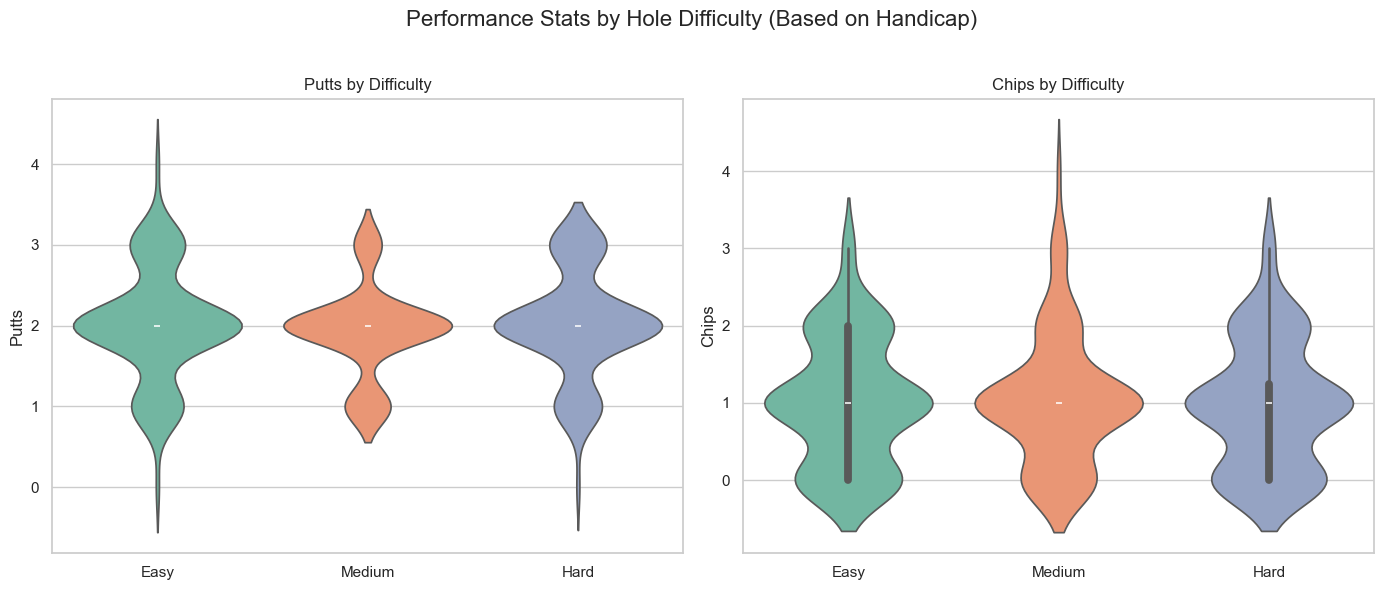

In [150]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Putts
sns.violinplot(data=golf, x='difficulty', y='putts', palette='Set2',
               order=['Easy', 'Medium', 'Hard'], ax=axes[0])
axes[0].set_title('Putts by Difficulty')
axes[0].set_ylabel('Putts')
axes[0].set_xlabel('')

# Chips
sns.violinplot(data=golf, x='difficulty', y='chips', palette='Set2',
               order=['Easy', 'Medium', 'Hard'], ax=axes[1])
axes[1].set_title('Chips by Difficulty')
axes[1].set_ylabel('Chips')
axes[1].set_xlabel('')

# Layout
plt.suptitle('Performance Stats by Hole Difficulty (Based on Handicap)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Just a couple more violin plots, since they are of course my favorite. Not much to see here. I sort of thought there would be way more putts and chips on hard holes. There are slightly more 3 putts, but for the most part the distributions look pretty similar across the groups

### Breakdown by Hole Number

Based on emperical evidence, I think I have a tendency to flame out at the end of the round. Whether it is fatigue or nerves about potentially breaking a scoring barrier and reaching a personal [Megabonus](https://as1.ftcdn.net/v2/jpg/05/74/23/44/1000_F_574234491_ajk2W6MYHXdMqOhuVCyaanvTf1u0AnCG.jpg), I find I often blow up near the end. Let's find out if that is backed by the data, breaking the holes into three `Periods` (holes 1-6, 7-12, and 13-18). 

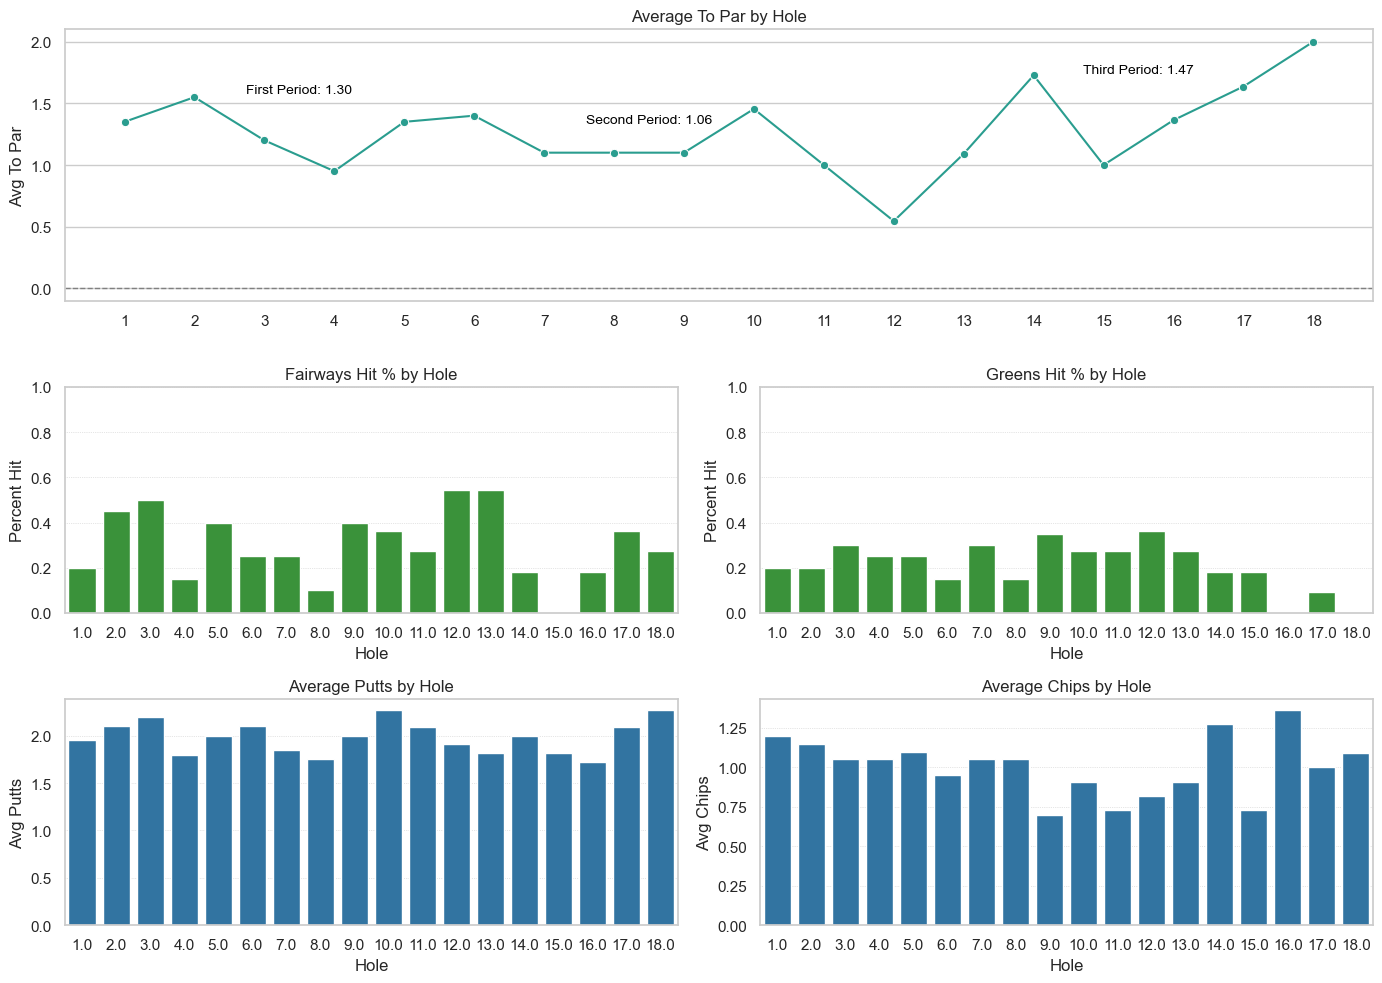

In [168]:
# Define the period based on hole number
golf['period'] = pd.cut(
    golf['hole'],
    bins=[0, 6, 12, 18],
    labels=['First Period', 'Second Period', 'Third Period'],
    right=True
)

# Create dummy hit columns
golf['fairway_hit'] = (golf['fairway'] == 'hit').astype(int)
golf['green_hit'] = (golf['green'] == 'hit').astype(int)

# Group by hole
grouped = golf.groupby('hole').agg({
    'to_par': 'mean',
    'fairway_hit': 'mean',
    'green_hit': 'mean',
    'putts': 'mean',
    'chips': 'mean'
}).reset_index()

# Group by period to annotate averages
period_averages = golf.groupby('period')['to_par'].mean().to_dict()
period_positions = {
    'First Period': 3.5,
    'Second Period': 8.5,
    'Third Period': 15.5
}

# Layout: 3 rows, 2 columns
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1, 1])
axes = [fig.add_subplot(gs[0, :]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, 0]),
        fig.add_subplot(gs[2, 1])]

# Top plot: to_par
sns.lineplot(data=grouped, x='hole', y='to_par', ax=axes[0], color='#2a9d8f', marker='o')
axes[0].set_title('Average To Par by Hole')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].set_ylabel('Avg To Par')
axes[0].set_xlabel('')
axes[0].grid(axis='x', visible=False) 
axes[0].set_xticks(range(1, 19))

# Annotate averages for each period
for period, x_pos in period_positions.items():
    avg = period_averages[period]
    axes[0].text(x_pos, avg + 0.28, f'{period}: {avg:.2f}', ha='center', fontsize=10, color='black')

# Bottom plots
sns.barplot(data=grouped, x='hole', y='fairway_hit', ax=axes[1], color='#2ca02c')
axes[1].set_title('Fairways Hit % by Hole')
axes[1].set_ylabel('Percent Hit')
axes[1].set_ylim(0, 1)

sns.barplot(data=grouped, x='hole', y='green_hit', ax=axes[2], color='#2ca02c')
axes[2].set_title('Greens Hit % by Hole')
axes[2].set_ylabel('Percent Hit')
axes[2].set_ylim(0, 1)

sns.barplot(data=grouped, x='hole', y='putts', ax=axes[3], color='#1f77b4')
axes[3].set_title('Average Putts by Hole')
axes[3].set_ylabel('Avg Putts')

sns.barplot(data=grouped, x='hole', y='chips', ax=axes[4], color='#1f77b4')
axes[4].set_title('Average Chips by Hole')
axes[4].set_ylabel('Avg Chips')

# Final formatting
for ax in axes[1:]:
    ax.set_xlabel('Hole')
    ax.grid(axis='x', visible=False)
    ax.grid(axis='y', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()


The answer to my question is yes. The numbers do back up my theory that I flame out at the end. In the `Third Period`, I average almost 1.5 strokes over par, compared to 1.18 for the first two periods.

The more important ask is what causes these higher scores. While there are some spikes, it doesn't look like I get particularly worse and chipping or putting late in the round. The bigger drop off is in fairways and greens. I need to get off the tee better, to set myself up for a better 2nd and 3rd shot.

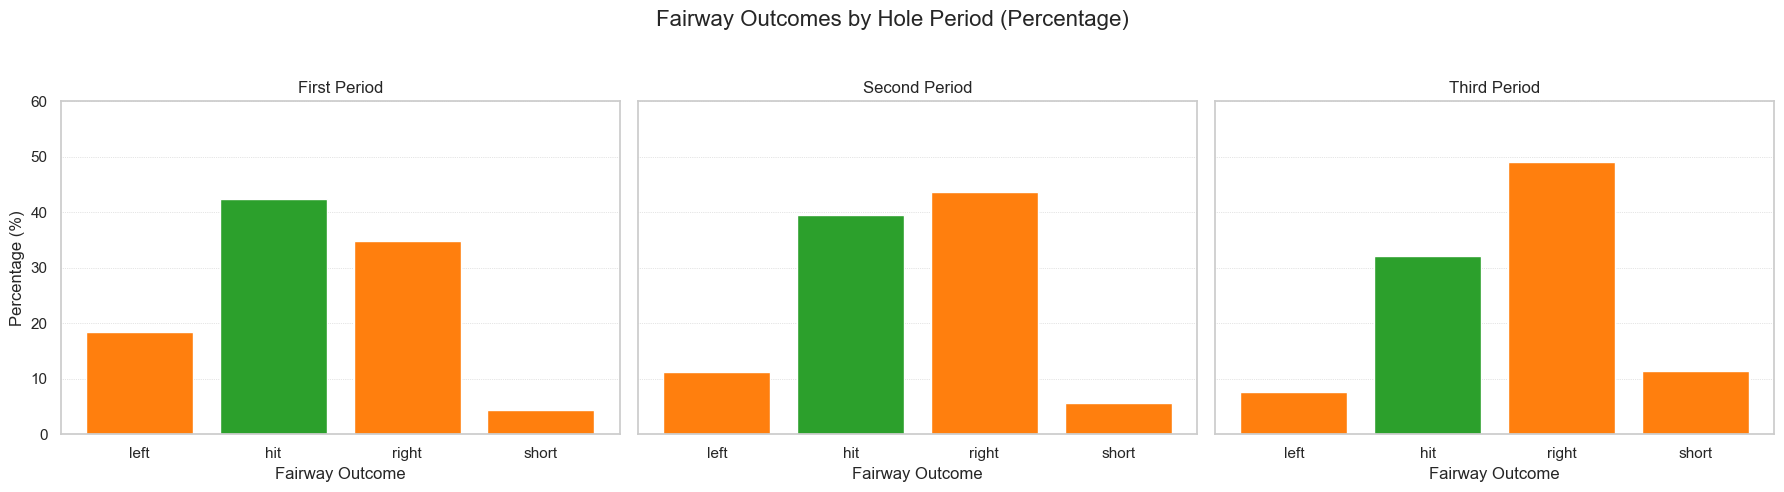

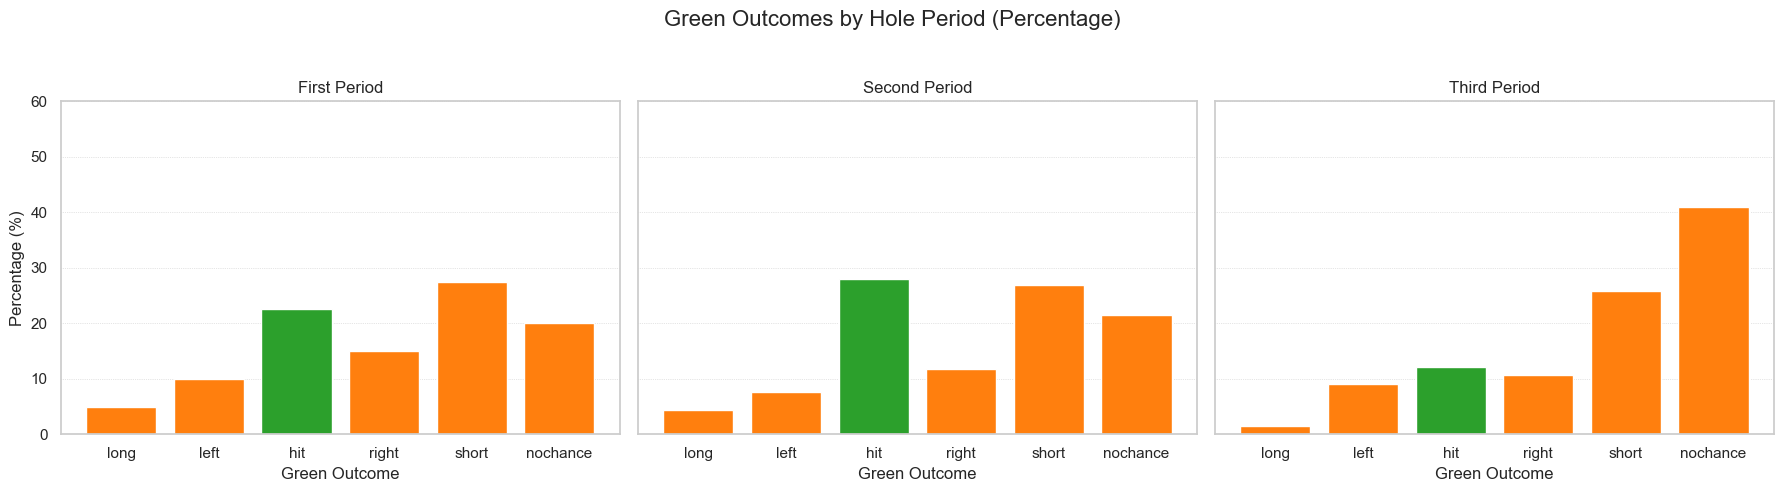

In [161]:
# Fairway outcome settings
fairway_order = ['left', 'hit', 'right', 'short']
colors_fairway = ['#ff7f0e', '#2ca02c', '#ff7f0e', '#ff7f0e']
period_order = ['First Period', 'Second Period', 'Third Period']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, period in enumerate(period_order):
    ax = axes[i]
    subset = golf[golf['period'] == period]
    counts = subset['fairway'].value_counts(normalize=True).reindex(fairway_order, fill_value=0) * 100

    ax.bar(fairway_order, counts.values, color=colors_fairway)
    ax.set_title(period)
    ax.set_xlabel('Fairway Outcome')
    if i == 0:
        ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 60)
    ax.grid(axis='x', visible=False)
    ax.grid(axis='y', linestyle=':', linewidth=0.5)

plt.suptitle('Fairway Outcomes by Hole Period (Percentage)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Green outcome settings
green_order = ['long', 'left', 'hit', 'right', 'short', 'nochance']
colors_green = ['#ff7f0e'] * 6
colors_green[2] = '#2ca02c'  # Make 'hit' green

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, period in enumerate(period_order):
    ax = axes[i]
    subset = golf[golf['period'] == period]
    counts = subset['green'].value_counts(normalize=True).reindex(green_order, fill_value=0) * 100

    ax.bar(green_order, counts.values, color=colors_green)
    ax.set_title(period)
    ax.set_xlabel('Green Outcome')
    if i == 0:
        ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 60)
    ax.grid(axis='x', visible=False)
    ax.grid(axis='y', linestyle=':', linewidth=0.5)

plt.suptitle('Green Outcomes by Hole Period (Percentage)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

This breakdown backs up what we were seeing before. The majority of my missed greens in the Third Period are because of bad tee balls, leaving me no chance to hit the green. In fact, the proportion of holes like this is almost identical to the 6 hardest holes by handicap (~40%). I am getting off the tee equally poorly in the hardest holes and latest holes on the golf course.

Now we have a better understanding of the data. Let's dig a little deeper with some `Conditional Expectations`

# My Gameplan - Conditional Expectations

To build a gameplan for myself, I first need to understand how the `Expected Value` (EV) of my score changes in different situations. 

We will look at different combinations of hole types, as well as what happens once I hit my tee shot in different locations.

## Hole Period and Difficuly -- Expected Values

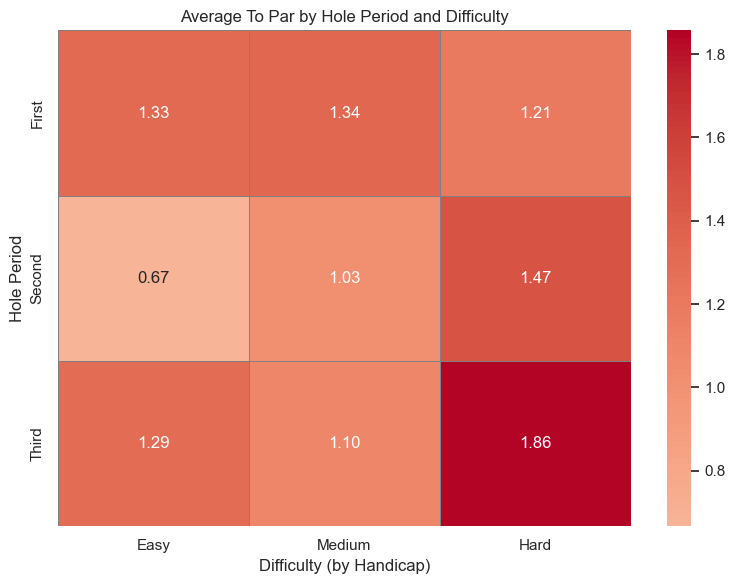

In [174]:
# Ensure clean numeric data
golf['to_par'] = pd.to_numeric(golf['to_par'], errors='coerce')

# Redefine difficulty and period just to be safe
golf['difficulty'] = pd.cut(
    golf['handicap'],
    bins=[0, 6, 12, 18],
    labels=['Hard', 'Medium', 'Easy'],
    right=True
)

golf['period'] = pd.cut(
    golf['hole'],
    bins=[0, 6, 12, 18],
    labels=['First', 'Second', 'Third'],
    right=True
)

# Drop rows with missing key values
heatmap_df = golf.dropna(subset=['to_par', 'difficulty', 'period'])

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table: Average to_par by period and difficulty
heatmap_data = heatmap_df.pivot_table(
    index='period',
    columns='difficulty',
    values='to_par',
    aggfunc='mean'
).reindex(index=['First', 'Second', 'Third'], columns=['Easy', 'Medium', 'Hard'])

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5, linecolor='gray')
plt.title('Average To Par by Hole Period and Difficulty')
plt.xlabel('Difficulty (by Handicap)')
plt.ylabel('Hole Period')
plt.tight_layout()
plt.show()

Above, we have a table of my expected score to par in different combinations of hole difficulty and time throughout a round. For example, on hard holes late in the round, I average 1.86 strokes to par. On easy holes in the middle of the round, I average 0.67.  

Below, we will look at my average strokes to par, given different tee balls, and given different approach shots.

In [169]:
fairway_to_par = golf.groupby('fairway')['to_par'].mean().sort_values()
fairway_to_par

fairway
hit      1.035714
right    1.505618
left     1.586207
short    2.071429
Name: to_par, dtype: float64

In [175]:
green_to_par = golf.groupby('green')['to_par'].mean().sort_values()
green_to_par

green
hit         0.196721
long        1.181818
left        1.360000
right       1.361111
short       1.386667
nochance    1.971831
Name: to_par, dtype: float64

Everything we are seeing to this point makes sense. "Hit fairways & greens = Good. Miss short of the fairway = Bad."

Now, let's combine these variables to dig a little deeper.

In [311]:
conditions_df = golf.dropna(subset=['period', 'difficulty', 'fairway', 'to_par'])

# Compute both expected value and sample size
expected_table = (
    conditions_df
    .groupby(['period', 'difficulty', 'fairway'])['to_par']
    .agg(expected_to_par='mean', sample_size='count')
    .reset_index()
    .sort_values(by='expected_to_par', ascending=True)
)

In [312]:
# Pivot the expected values
pivot = expected_table.dropna().pivot_table(
    values='expected_to_par',
    index='fairway',
    columns=['period', 'difficulty']
)

# Rank across all values (flattened), then reshape back to original pivot shape
flat_ranked = pivot.stack().rank().unstack()

# Style with color by overall rank
styled = pivot.style.background_gradient(
    cmap='RdYlGn_r', axis=None, gmap=flat_ranked
).format("{:.2f}")

styled

The pivot table above shows how different fairway misses affect my score on different holes. Interestingly, left misses seem to hurt less than right misses, likely because a right miss can often come with a big slice. It also looks like this slice is worse at the beginning of the round. The right miss hurts me a lot more early than it does late. Keeping a smooth tempo early in the round until I get comfortable could help me mitigate large numbers early on.

# Building a Model

All those analytics are great, but it is time to build a machine learning model to see how the computer synthesises all of this information. Given I do not have a lot of data, and I am dealing with categorical, nonlinear data, I have settled on using a `Decision Tree Regressor`. I like this option particularly because it is not a black box - we can visualize the tree and interpret how it makes its decisions predicting my score.

The important part of this exercise is not predicting scores, but understanding the impacts of different features in creating the predictions. 

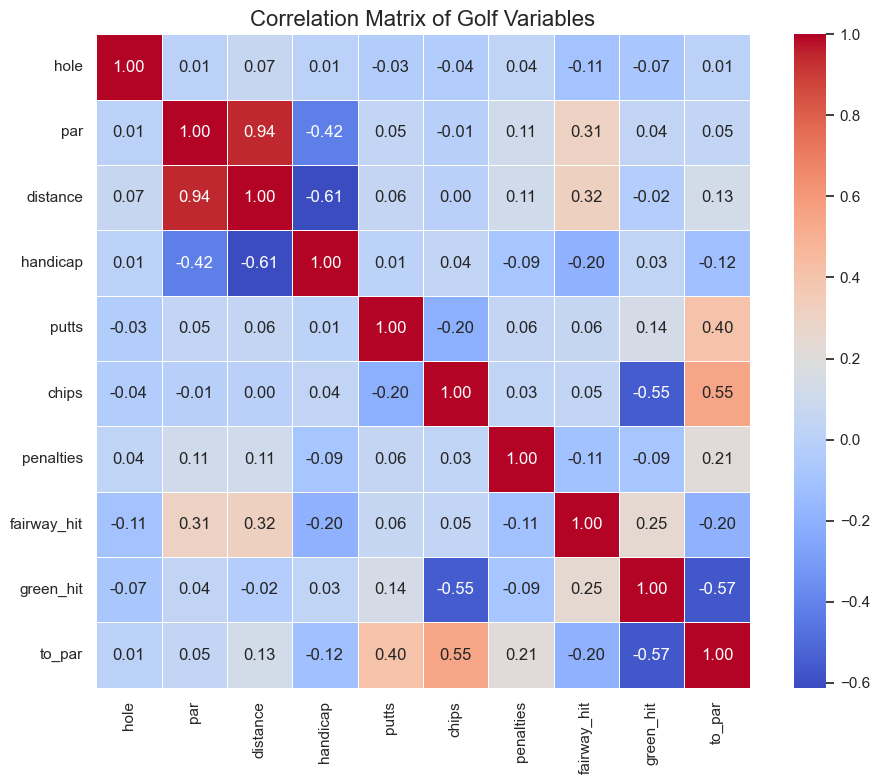

In [213]:
# Select only the numeric columns for correlation
numeric_cols = [
    'hole', 'par', 'distance', 'handicap', 'putts',
    'chips', 'fairway_hit', 'green_hit', 'to_par'
]

# Drop rows with any missing values in selected columns
golf_corr = golf[numeric_cols].dropna()

# Compute correlation matrix
corr_matrix = golf_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix of Golf Variables', fontsize=16)
plt.tight_layout()
plt.show()


Above is a correlation matrix. This shows how much each numerical variable is correlated with each other. Darker colors indicate more correlation, and hue indicates directionality. According to this, hitting greens and minimizing chips and putts are the most important variables to lower my score `to_par`.

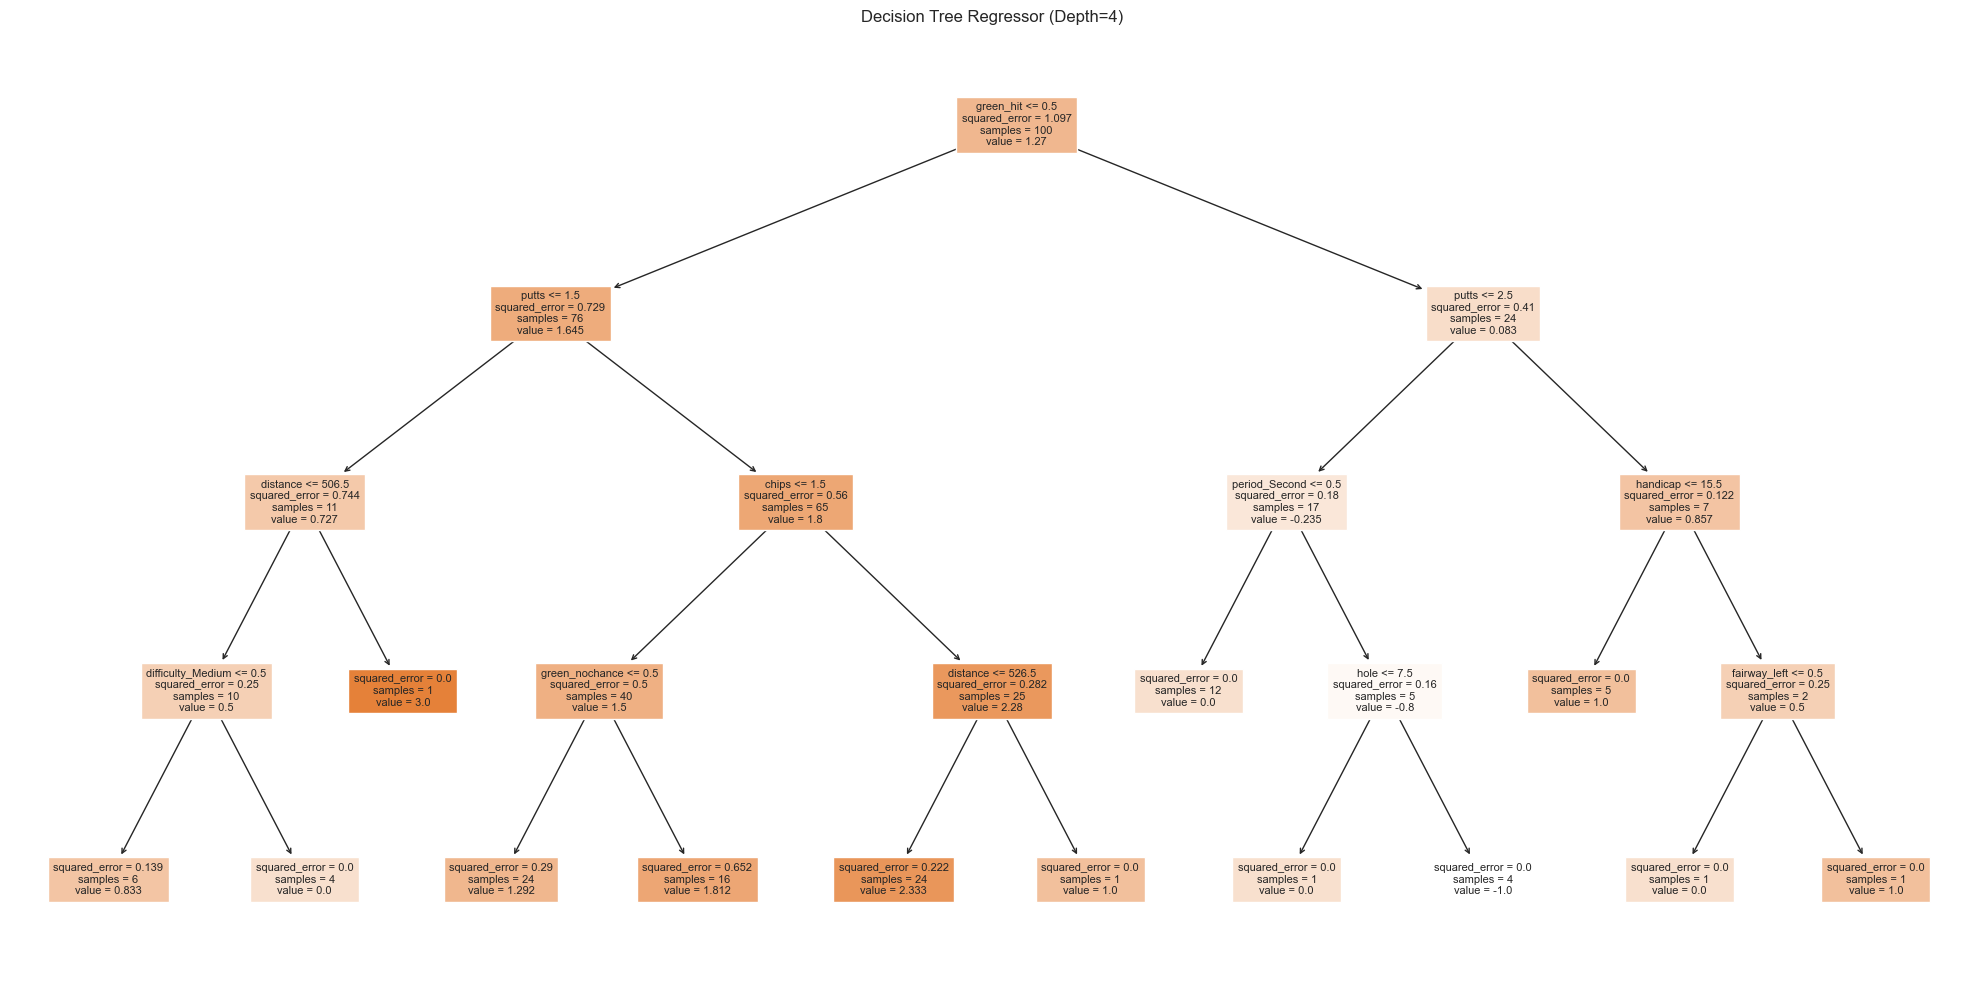

R-Squared: 0.41118309620596205


In [221]:
# Drop rows with missing target variable
golf = golf.dropna(subset=['to_par'])

# Select features and target
categorical_cols = ['fairway', 'green', 'difficulty', 'period']
numerical_cols = ['hole', 'par', 'distance', 'handicap', 'putts', 'chips', 'penalties', 'fairway_hit', 'green_hit']
features = categorical_cols + numerical_cols

# Drop rows with missing values in the selected features
golf = golf.dropna(subset=features)

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cat = encoder.fit_transform(golf[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

# Combine numerical and encoded categorical features
X = pd.concat([golf[numerical_cols].reset_index(drop=True), encoded_cat_df], axis=1)
y = golf['to_par'].reset_index(drop=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree regressor
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, fontsize=8)
plt.title("Decision Tree Regressor (Depth=4)")
plt.tight_layout()
plt.show()

print(f"R-Squared: {r2}")


As described, here is our Decision Tree visualized. This model has an R-Squared value of 0.411, meaning it explains about 40% of the variance in my score - pretty solid for such a random value, with such little data.

You can read the tree yourself. Each node has a decision at the top of it. For example, the first decision point is `green_hit <= 0.5`. In english, this is asking: "Did I miss the green?". Under the node, there will be two arrows. The arrow to the left answers "Yes" to this deision point, and the arrow to the right answers "No". You can see that in the node to the right under this first decision point, the value is `0.083`. This means that if I hit the green, this is my expected score to par. You can continue following the logic of the tree, understanding that each subsequent decision point includes the answers to all previous decision points as its base scenario. At the bottom, the terminal nodes represent the expected scores to par for each of the 13 identified most influential combinations of predictors and values.

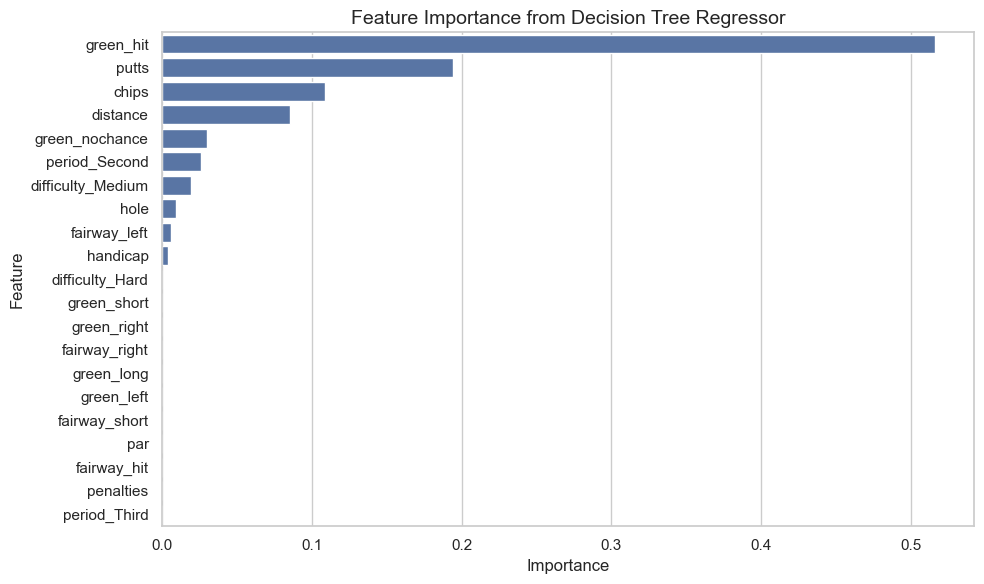

In [227]:
importances = tree_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance from Decision Tree Regressor', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This is a feature importance plot, which tells us exactly what it sounds like. Which predictors are most important for predicting score? For this model, the answer is:

- Hitting greens
- Putting
- Chipping
- Hole distance

### Doubles or Worse

Next, I wanted to adjust the model a little bit. Predicting scores is great, but as a high handicap I really need to focus more on eliminating the blow-ups. This model below is a `Decision Tree Classifier`, attempting to predict which holes will score a double or worse.

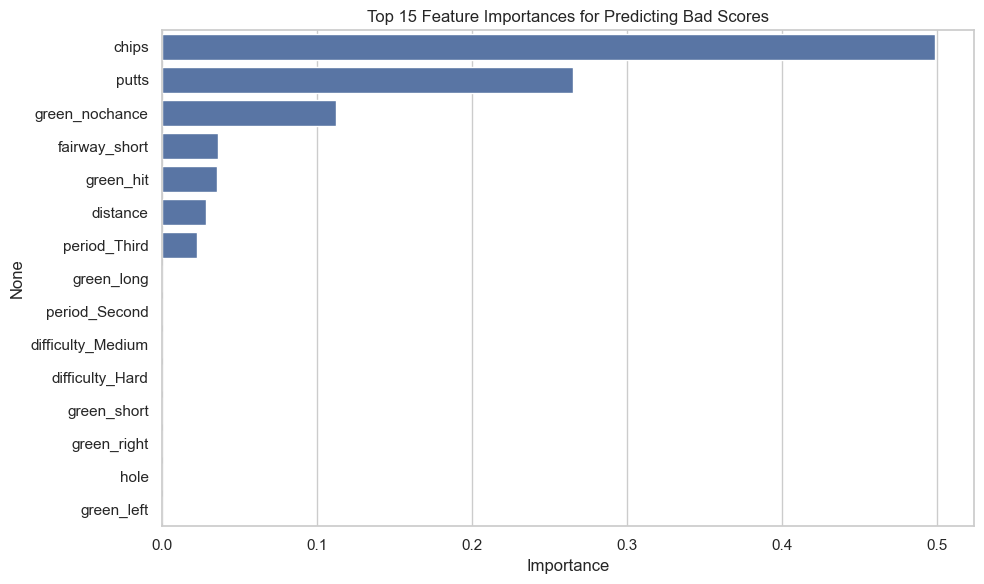

              precision    recall  f1-score     support
0              0.928571  0.902778  0.915493   72.000000
1              0.875000  0.907407  0.890909   54.000000
accuracy       0.904762  0.904762  0.904762    0.904762
macro avg      0.901786  0.905093  0.903201  126.000000
weighted avg   0.905612  0.904762  0.904957  126.000000
[[65  7]
 [ 5 49]]


In [236]:
# Assume golf DataFrame is loaded in the environment
# Create a binary classification target: bad_score
golf['bad_score'] = (golf['to_par'] >= 2).astype(int)

# Define features
categorical_cols = ['fairway', 'green', 'difficulty', 'period']
numerical_cols = ['hole', 'par', 'distance', 'handicap', 'putts', 'chips', 'penalties', 'fairway_hit', 'green_hit']
features = categorical_cols + numerical_cols

# Drop rows with missing values in features or target
golf = golf.dropna(subset=features + ['bad_score'])

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cat = encoder.fit_transform(golf[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

# Combine numerical and encoded categorical features
X_class = pd.concat([golf[numerical_cols].reset_index(drop=True), encoded_cat_df], axis=1)
y_class = golf['bad_score'].reset_index(drop=True)

# Train-test split
#X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Train decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_class, y_class)

# Predict
y_pred_c = clf.predict(X_class)

# Metrics
conf_matrix = confusion_matrix(y_class, y_pred_c)
report = classification_report(y_class, y_pred_c, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Feature importance
feature_importance = pd.Series(clf.feature_importances_, index=X_class.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values[:15], y=feature_importance.index[:15])
plt.title('Top 15 Feature Importances for Predicting Bad Scores')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print(report_df)
print(conf_matrix)


This model peformed very well, with all accuracy metrics being above 0.85. We should take this with a grain of salt, as I did not split up training and testing data. There is not enough data here to do that and get an accurate ML model. That doesn't really matter, however, as the most important takeaways here come from Feature Importance.

We can see the big difference clearly. The most influential feature for predicting bad holes is `chips`. This is different from the first model, and important to remember on the course: The model tells me that my tee shots and approaches are good enough to not be a huge predictor of when I blow up. My blow ups are primarily caused by my short game. This means that even when I go OB, I need to remember that my most important shots are yet to come.

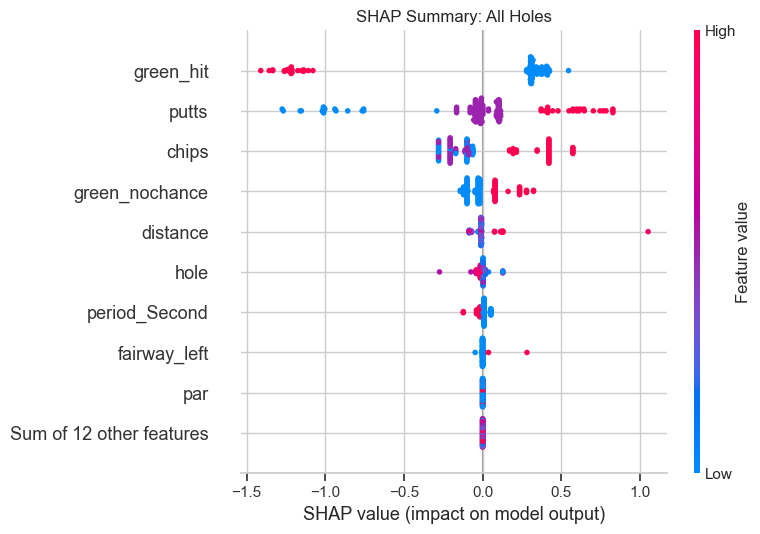

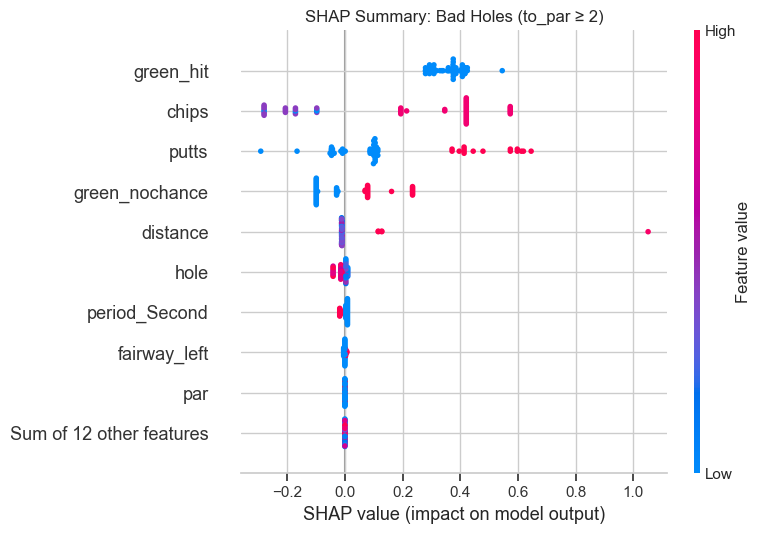

In [233]:
# Ensure clean data
golf = golf.dropna(subset=['to_par'])

# Define features
categorical_cols = ['fairway', 'green', 'difficulty', 'period']
numerical_cols = ['hole', 'par', 'distance', 'handicap', 'putts', 'chips', 'penalties', 'fairway_hit', 'green_hit']
features = categorical_cols + numerical_cols

# Drop rows with missing feature values
golf = golf.dropna(subset=features)

# One-hot encode categoricals
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cat = encoder.fit_transform(golf[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

# Combine features
X_encoded = pd.concat([golf[numerical_cols].reset_index(drop=True), encoded_cat_df], axis=1)
y = golf['to_par'].reset_index(drop=True)

# Train full decision tree model
tree_model_full = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model_full.fit(X_encoded, y)

# Compute SHAP values
explainer = shap.Explainer(tree_model_full, X_encoded)
shap_values = explainer(X_encoded)

# Plot SHAP summary for all holes
plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Summary: All Holes")
plt.tight_layout()
plt.show()

# Filter for bad scores
bad_scores_idx = y[y >= 2].index.tolist()
shap_values_bad = shap_values[bad_scores_idx]

# Plot SHAP summary for bad scoring holes
plt.figure()
shap.plots.beeswarm(shap_values_bad, show=False)
plt.title("SHAP Summary: Bad Holes (to_par ≥ 2)")
plt.tight_layout()
plt.show()

`Shapley Values` show feature importance on a case-by-case basis. While feature importance plots show which predictors are important to the model in general, Shapley values tell us: For a given prediction, which specific values of each predictors were most influential? For example, on a hole where I 4 putt, putts are going to be way more influential than a hole where I two-putt, but hit my tee shot OB.

These plots (first for the regressor, then for the classifier) mainly confirm what we already knew. Greens and putts are important for scoring low, while chips and putts are generally the cause for my blow up holes.

# Simulation

Now that we have a decision tree to (somewhat) accurately predict score, we can build a `Monte Carlo` simulation to see what our scoring distribution should look like, then adjust input parameters to see what we can do to actually lower our expected handicap.

Before we do this, we need to understand how handicap is calculated. Lots of golfers have trouble with this, so please enjoy this [ChatGPT](chatgpt.com) created explanation:

### 📉 What Percentile is My Handicap?

**Handicap rule**: A golf handicap is calculated as the **average of your best 8 scores from your last 20 rounds**.

We want to know:  
> What **percentile** that score would fall into if your scores follow a normal distribution?

---

#### 📐 Assumptions:
- Scores follow a **normal distribution** with mean \( \mu \) and standard deviation \( \sigma \).
- Your handicap is based on the **average of the lowest 8 scores** out of 20.

---

#### 📊 Expected Value of Best 8 of 20 Scores:

The average of the **lowest 8 out of 20** values drawn from a standard normal distribution is approximately:

`MATH DOESN'T RENDER WELL IN MARKDOWN. DON'T WORRY ABOUT IT.`

---

#### 📈 Percentile Calculation:

`AGAIN, DON'T WORRY ABOUT IT. THE ANSWER IS:` **Approximately 17.2%**

---

### ✅ Final Answer:

> Your handicap score represents roughly the **17th percentile** of your full scoring distribution.

This means:
- You play **to or better than your handicap** about **17% of the time**.
- It is a measure of **potential**, not average performance.

#### Ok. So in our simulated scoring distribution, we need our 17th percentile to be 15 strokes over par in order to reach my goal.

In [268]:
# Ensure tree_model and X are already defined from your earlier training
feature_names = X.columns

# Number of simulations and holes per round
num_simulations = 5000
holes_per_round = 18

# Simulate one round by sampling from feature distributions
def simulate_one_round(X, model, holes=18):
    simulated_round = []
    for _ in range(holes):
        simulated_features = {}
        for col in X.columns:
            if X[col].dtype.name == 'category' or X[col].dtype == object:
                simulated_features[col] = np.random.choice(X[col].dropna().unique())
            else:
                simulated_features[col] = np.random.choice(X[col].dropna().values)
        row_df = pd.DataFrame([simulated_features])
        to_par = model.predict(row_df)[0]
        simulated_round.append(to_par)
    return sum(simulated_round)

# Run simulations
simulated_scores = [simulate_one_round(X, tree_model, holes=holes_per_round) for _ in range(num_simulations)]

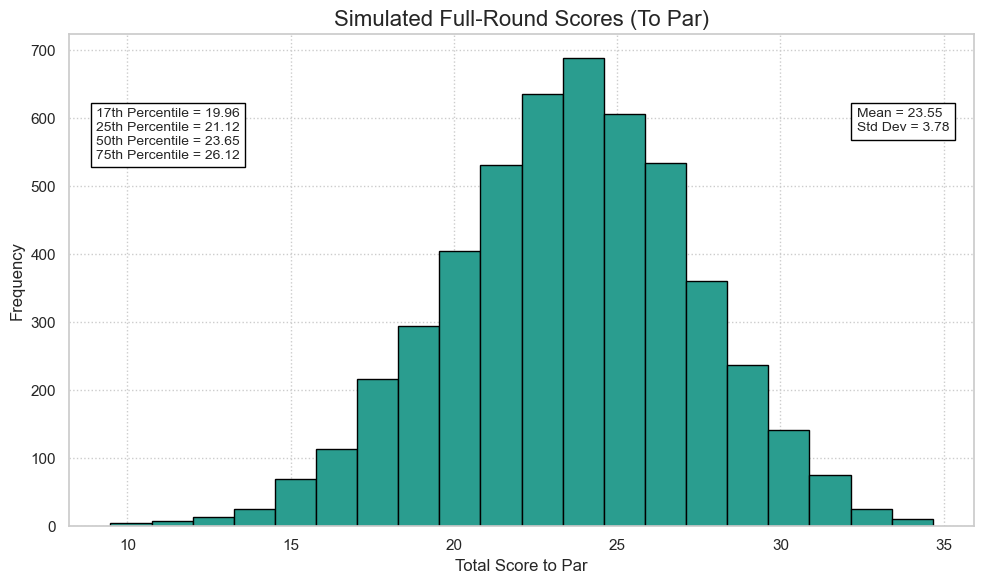

In [276]:
# Reusing previously simulated scores
mean_score = np.mean(simulated_scores)
std_score = np.std(simulated_scores)
percentiles = np.percentile(simulated_scores, [17, 25, 50, 75])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(simulated_scores, bins=20, color='#2a9d8f', edgecolor='black')
plt.title('Simulated Full-Round Scores (To Par)', fontsize=16)
plt.xlabel('Total Score to Par')
plt.ylabel('Frequency')
plt.grid(True, linestyle=':')

# Annotate statistics
plt.text(plt.xlim()[0]*1.1, plt.ylim()[1]*0.85, 
         f"17th Percentile = {percentiles[0]:.2f}\n25th Percentile = {percentiles[1]:.2f}\n50th Percentile = {percentiles[2]:.2f}\n75th Percentile = {percentiles[3]:.2f}", 
         verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
plt.text(plt.xlim()[1]*.9, plt.ylim()[1]*0.85, 
         f"Mean = {mean_score:.2f}\nStd Dev = {std_score:.2f}", 
         verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
plt.tight_layout()
plt.show()


This is my simulated scoring distribution as it currently stands, assuming I play about average according to my last 20 rounds. My expected handicap is slightly lower than it really is, but in general this is a solid model that accurately represents reality.

Now, let's use some of the key influencers of my score to create **reasonable goals** to attempt to **lower my scoring distribution**.

First, we will improve my chipping. Let's assume that when I miss the green, I only double-chip 10% of the time. When I hit a wayward tee shot with no chance to hit the green on my approach, I'll be allowed to double-chip 25% of the time.

In [464]:
# Load model and data again (assumes tree_model and X_encoded already exist from previous steps)
model = tree_model  # Using the original trained model

# Extract the features used in the model
predictor_columns = X_encoded.columns.tolist()

# Function to simulate rounds
def simulate_rounds_custom1(model, X_encoded, n_simulations=500, holes_per_round=18):
    # Sample values from each column independently
    sim_data = X_encoded.sample(n=n_simulations * holes_per_round, replace=True).reset_index(drop=True)

    # --- Custom chip logic ---
    green_nochance_cols = [col for col in sim_data.columns if 'green_nochance' in col]
    green_hit_cols = [col for col in sim_data.columns if 'green_hit' in col]

    if green_nochance_cols and green_hit_cols:
        green_nochance_col = green_nochance_cols[0]
        green_hit_col = green_hit_cols[0]

        green_nochance = sim_data[green_nochance_col] == 1
        green_hit = sim_data[green_hit_col] == 1
        green_not_hit = ~green_hit

        # 1. For green_nochance rows: 75% get 1 chip, 25% get 2 chips
        sim_data.loc[green_nochance, 'chips'] = np.random.choice([1, 2], size=green_nochance.sum(), p=[0.75, 0.25])

        # 2. For other green misses (not green_nochance): 90% get 1 chip, 10% get 2 chips
        other_miss = green_not_hit & ~green_nochance
        sim_data.loc[other_miss, 'chips'] = np.random.choice([1, 2], size=other_miss.sum(), p=[0.90, 0.10])

        # 3. Fill remaining chips with 0 and cap at 2 just in case
        sim_data['chips'] = sim_data['chips'].fillna(0)
        sim_data['chips'] = np.minimum(sim_data['chips'], 2)

    # --- Predict to_par for 18 holes per simulation ---
    to_par_per_hole = model.predict(sim_data[predictor_columns])
    simulated_scores = to_par_per_hole.reshape(-1, holes_per_round).sum(axis=1)

    return simulated_scores

# Run simulation
simulated_scores_custom1 = simulate_rounds_custom1(model, X_encoded)

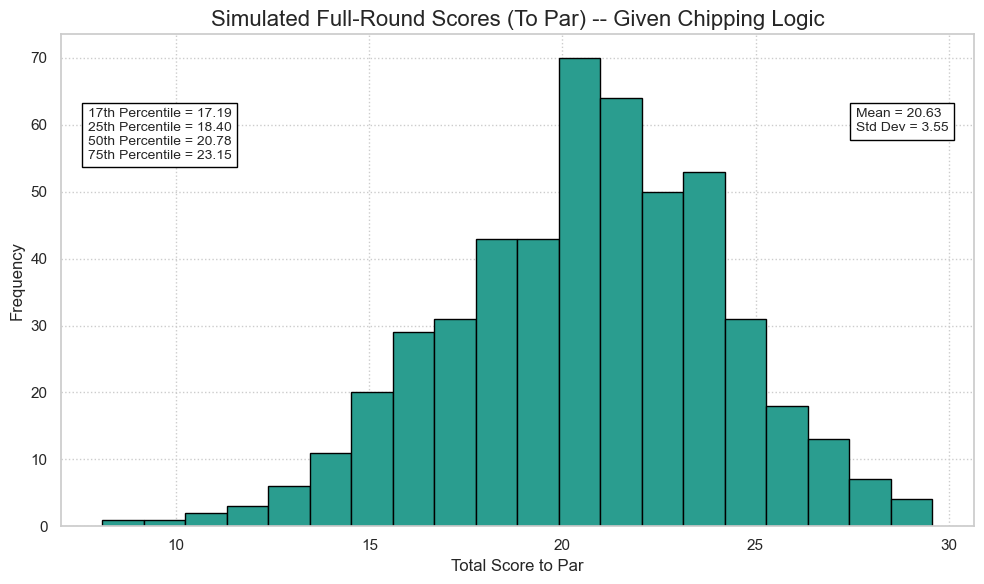

In [465]:
# Reusing previously simulated scores
mean_score = np.mean(simulated_scores_custom1)
std_score = np.std(simulated_scores_custom1)
percentiles = np.percentile(simulated_scores_custom1, [17, 25, 50, 75])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(simulated_scores_custom1, bins=20, color='#2a9d8f', edgecolor='black')
plt.title('Simulated Full-Round Scores (To Par) -- Given Chipping Logic', fontsize=16)
plt.xlabel('Total Score to Par')
plt.ylabel('Frequency')
plt.grid(True, linestyle=':')

# Annotate statistics
plt.text(plt.xlim()[0]*1.1, plt.ylim()[1]*0.85, 
         f"17th Percentile = {percentiles[0]:.2f}\n25th Percentile = {percentiles[1]:.2f}\n50th Percentile = {percentiles[2]:.2f}\n75th Percentile = {percentiles[3]:.2f}", 
         verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
plt.text(plt.xlim()[1]*.9, plt.ylim()[1]*0.85, 
         f"Mean = {mean_score:.2f}\nStd Dev = {std_score:.2f}", 
         verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
plt.tight_layout()
plt.show()

Alright! This fictional world is getting better. If I focus on my chipping and reach those goals listed above, my expected average score will drop to approx 20 over par, and I will be about a 17 handicap.

Let's keep going. We know that I play worse at the end of the round. What if I set a goal to keep my tee shot in play at least 80% of the time on the last 6 holes? This means, limit those holes to 1 instance of having no chance to hit the green.

I am also adding in the very reasonable goal of no 4 putts or worse.

In [474]:
# Load model and data again (assumes tree_model and X_encoded already exist)
model = tree_model
predictor_columns = X_encoded.columns.tolist()

def simulate_rounds_custom2(model, X_encoded, n_simulations=500, holes_per_round=18):
    sim_data = X_encoded.sample(n=n_simulations * holes_per_round, replace=True).reset_index(drop=True)

    # Identify green_nochance and green_hit columns
    green_nochance_cols = [col for col in sim_data.columns if 'green_nochance' in col]
    green_hit_cols = [col for col in sim_data.columns if 'green_hit' in col]

    if green_nochance_cols and green_hit_cols:
        green_nochance_col = green_nochance_cols[0]
        green_hit_col = green_hit_cols[0]

        # Default green_nochance to 0
        sim_data[green_nochance_col] = 0

        # Limit green_nochance to ~20% for holes 13 through 18
        high_hole_idx = sim_data['hole'].isin([13, 14, 15, 16, 17, 18])
        sim_data.loc[high_hole_idx, green_nochance_col] = np.random.binomial(1, 0.2, size=high_hole_idx.sum())

        # Recalculate green logic masks
        green_nochance = sim_data[green_nochance_col] == 1
        green_hit = sim_data[green_hit_col] == 1
        green_not_hit = ~green_hit

        # Chip logic
        # 1. green_nochance: 75% 1 chip, 25% 2 chips
        sim_data.loc[green_nochance, 'chips'] = np.random.choice([1, 2], size=green_nochance.sum(), p=[0.75, 0.25])

        # 2. green_not_hit but not green_nochance: 90% 1 chip, 10% 2 chips
        other_miss = green_not_hit & ~green_nochance
        sim_data.loc[other_miss, 'chips'] = np.random.choice([1, 2], size=other_miss.sum(), p=[0.90, 0.10])

        # 3. Fill in 0s for everything else and cap at 2
        sim_data['chips'] = sim_data['chips'].fillna(0)
        sim_data['chips'] = np.minimum(sim_data['chips'], 2)

    sim_data['putts'] = np.minimum(sim_data['putts'], 3)

    # Predict to_par for each hole and sum up to get round score
    to_par_per_hole = model.predict(sim_data[predictor_columns])
    simulated_scores = to_par_per_hole.reshape(-1, holes_per_round).sum(axis=1)

    return simulated_scores

# Run simulation
simulated_scores_custom2 = simulate_rounds_custom2(model, X_encoded)

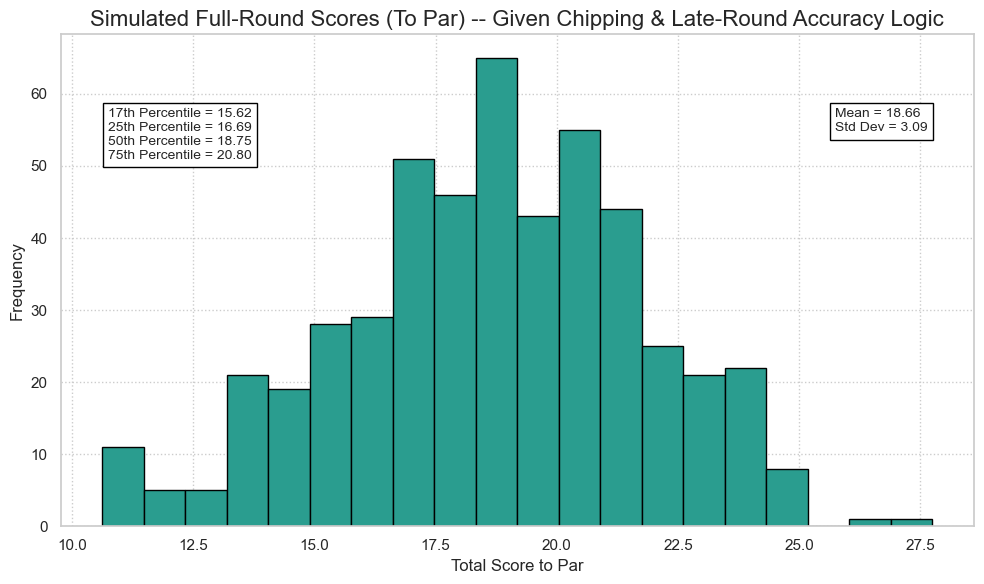

In [475]:
# Reusing previously simulated scores
mean_score = np.mean(simulated_scores_custom2)
std_score = np.std(simulated_scores_custom2)
percentiles = np.percentile(simulated_scores_custom2, [17, 25, 50, 75])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(simulated_scores_custom2, bins=20, color='#2a9d8f', edgecolor='black')
plt.title('Simulated Full-Round Scores (To Par) -- Given Chipping & Late-Round Accuracy Logic', fontsize=16)
plt.xlabel('Total Score to Par')
plt.ylabel('Frequency')
plt.grid(True, linestyle=':')

# Annotate statistics
plt.text(plt.xlim()[0]*1.1, plt.ylim()[1]*0.85, 
         f"17th Percentile = {percentiles[0]:.2f}\n25th Percentile = {percentiles[1]:.2f}\n50th Percentile = {percentiles[2]:.2f}\n75th Percentile = {percentiles[3]:.2f}", 
         verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
plt.text(plt.xlim()[1]*.9, plt.ylim()[1]*0.85, 
         f"Mean = {mean_score:.2f}\nStd Dev = {std_score:.2f}", 
         verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))
plt.tight_layout()
plt.show()

And there we have it. Three simple goals:

- limit double chips (with some grace on holes with bad tee shots)
- No more than 1 ball out of play for the last 6 holes of the round
- No 4 putts

If I do this, my expected average score drops to around 18-19 over par, and my expected handicap will be 15.

# Conclusions

Thank you for joining me on this journey! I will try and keep this page updated as I continue to play, and hopefully as my scores drop (but you never know). Please feel free to reach out to me with any questions or comments. Go low, everyone!